# Setups

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
root_dir = "/content/drive/MyDrive/dl-final"
%cd $root_dir
!pip install tensorflow_addons

/content/drive/MyDrive/dl-final
     |████████████████████████████████| 706kB 16.5MB/s 


In [4]:
import os, sys
import numpy as np 
import time
import collections
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import scipy.io
from sklearn.metrics.pairwise import cosine_similarity
tf.get_logger().setLevel('ERROR')

In [5]:
data_dir = os.path.join(root_dir, "data")
res_feature_dir = os.path.join(data_dir, "Features", "ResNet101")

In [6]:
predicate_continuous = []
predicate_binary = []

f = open(os.path.join(data_dir, "predicate-matrix-continuous.txt"))
for line in f:
    p = np.array(line.strip().split()).astype(np.float)
    predicate_continuous += [p]
predicate_continuous = np.array(predicate_continuous)

f = open(os.path.join(data_dir, "predicate-matrix-binary.txt"))
for line in f:
    p = np.array(line.strip().split()).astype(np.float)
    predicate_binary += [p]
predicate_binary = np.array(predicate_binary)

print("Predicate Loaded. Shape: {}".format(predicate_binary.shape))

Predicate Loaded. Shape: (50, 85)


# Define functions

In [7]:
def findsubsets(S,m):
    if m == len(S):
        return S
    else:
        np_S = np.array(list(S))
        ind = np.random.choice(len(S), m, replace = False)
    return set(np_S[ind].tolist())

def validate_classes(train_classes, test_classes, preds, remove = True, raise_excpt = False):
    for p in range(85):
        selected_p = predicate_binary[list(train_classes),:][:,p]
        if selected_p.sum() == 0 or selected_p.sum() == len(train_classes): 
            if remove:
                #print("{}th predicate is not discriminative for training classes {}. Removed".format(p, test_classes)) 
                preds.remove(p)
            if raise_excpt:
                raise BaseException("{}th predicate is not discriminative for training classes {}".format(p, train_classes))
        
        selected_p = predicate_binary[list(test_classes),:][:,p]
        if selected_p.sum() == 0 or selected_p.sum() == len(test_classes): 
            if remove:
                #print("{}th predicate is not discriminative for test classes {}. Removed".format(p, test_classes)) 
                preds.remove(p)

    return True

def create_attr_net(input_size, layer_sizes = (1024,128), loss = tfa.losses.TripletSemiHardLoss(), optimizer = "sgd", lr = 1e-3, restore = None):

    first, second = layer_sizes
    if second <=1: 
        raise BaseException("Invalid output size")
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_size)) )

    if first:
        model.add(tf.keras.layers.Dense(first, activation="relu")) # No activation on final dense layer
        model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(second, activation=None))
    model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))) # L2 normalize embeddings

    model.compile(optimizer=optimizer,
              loss=loss)
    
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(lr = lr)
    elif optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(lr = lr)
    else:
        raise BaseException("Unsupported optimizer {}".format(optimizer) )

    if restore is not None:
        model.load_weights("./{}_{}/ckpt/weights_{}".format(*restore))

    return model


def create_attr_extractors(preds, train_x, train_y, create_net_func, predicates, \
                           layer_sizes = (1024,128), \
                           lr = 1e-3, \
                           batch_size = 128, \
                           epochs = 50, \
                           num_train = None, \
                           data_per_class = None, \
                           test = False ):
    models = {}
    true_means = {}
    false_means = {}

    pth = "./{}_{}".format(num_train, data_per_class)
    if not os.path.exists(pth):
        os.makedirs(pth)
        os.makedirs(os.path.join(pth,"ckpt"))

    for i, p in enumerate(preds):
        if not test:
            y_p = predicates[train_y,:][:,p]
            models[p] = create_attr_net(train_x.shape[1], layer_sizes = layer_sizes, lr = lr)
            history = models[p].fit(train_x, y_p, batch_size = batch_size, epochs = epochs, verbose = 0)
            if (i+1) % 5 == 0 and False:
                print("[INFO] Training attribute #{} out of {}".format(i+1, len(preds)))
                print("[INFO] Training done with loss = {}".format(history.history['loss'][-1]))
            models[p].save_weights("./{}_{}/ckpt/weights_{}".format(\
                num_train, data_per_class, p))
            x_preds = models[p](train_x).numpy()
            true_vecs =  x_preds[y_p == 1,:]
            false_vecs =  x_preds[y_p == 0,:]
            true_means[p] = np.mean(true_vecs, axis = 0)
            false_means[p] = np.mean(false_vecs, axis = 0)
            np.save("./{}_{}/mean_true_{}".format(num_train, data_per_class, p), true_means[p])
            np.save("./{}_{}/mean_false_{}".format(num_train, data_per_class, p), false_means[p])
        else:
            models[p] = create_attr_net(train_x.shape[1], lr = lr, \
                                    restore = (num_train, data_per_class, p))
            true_means[p] = np.load("./{}_{}/mean_true_{}.npy".format(num_train, data_per_class, p))
            false_means[p] = np.load("./{}_{}/mean_false_{}.npy".format(num_train, data_per_class, p))

    return models, true_means, false_means

def predict_cosine(models, preds, test_x, test_y, predicates, true_means, false_means): 

    pred_dict = {}
    for i, p in enumerate(preds):
        y_p = predicates[test_y,:][:,p]
        x_preds = models[p](test_x)
        f_score = 0.5*(1+cosine_similarity(x_preds, np.expand_dims(false_means[p],axis = 0))[:,0])
        t_score = 0.5*(1+cosine_similarity(x_preds, np.expand_dims(true_means[p], axis = 0))[:,0])
        pred_dict[p] = t_score / (t_score + f_score)

    return pred_dict

def calculate_acc(pred_dict, y, target_classes):
    preds = pred_dict.keys()
    list_preds = sorted(list(preds))

    predictions = []
    for p in sorted(list_preds):
        predictions += [pred_dict[p]]

    predictions = np.array(predictions).T
        
    top_1_correct = 0
    top_3_correct = 0

    for i,p in enumerate(predictions):
        dist = np.sum(np.abs(predicate_binary[:,sorted(list(preds))] - p), axis = 1).squeeze()
        order = np.argsort(dist)
        trimmed_order = []

        for rank in order:
            if rank in target_classes:
                trimmed_order += [rank]
        top_1_correct += y[i] == trimmed_order[0]
        top_3_correct += y[i] in trimmed_order[:3]
        
    prec1 = top_1_correct*1.0/len(y)
    prec3 = top_3_correct*1.0/len(y) 

    return prec1, prec3


# Define experiment

In [8]:
# training
# read these from args

#classes and preds are shifted to 0 based
def run_experiment(num_train, data_per_class, layer_sizes, epochs = 50,  batch_size = 128, lr = 1e-3, test = False):

    print("[INFO] Using at most {} train data per class".format(data_per_class))
    print("[INFO] Forming dataset...")


    split_info = scipy.io.loadmat(os.path.join(data_dir,'binaryAtt_splits.mat'))
    data =  scipy.io.loadmat(os.path.join(res_feature_dir,'res101.mat'))
    X = data['features'].T
    y = data['labels']-1
    train_x = X[split_info['trainval_loc']-1,:].squeeze()
    train_y = y[split_info['trainval_loc']-1].squeeze()
    test_s_x = X[split_info['test_seen_loc']-1,:].squeeze()
    test_s_y = y[split_info['test_seen_loc']-1,:].squeeze()
    test_u_x = X[split_info['test_unseen_loc']-1,:].squeeze()
    test_u_y = y[split_info['test_unseen_loc']-1,:].squeeze()

    indices = np.arange(0, train_x.shape[0])
    shuffled_indices = np.random.shuffle(indices)
    train_x = train_x[shuffled_indices,:].squeeze()
    train_y = train_y[shuffled_indices].squeeze()

    preds = set(range(85))
    seen_classes = set(train_y.tolist())
    unseen_classes = set(test_u_y.tolist())
    validate_classes(seen_classes, unseen_classes, preds, remove = True)# raise_excpt = True)
    
    counts = collections.defaultdict(int)
    train_x_sub, train_y_sub = [], []
    for tx, ty in zip(train_x, train_y):
        if  counts[ty] < data_per_class:
            train_y_sub += [ty]
            train_x_sub += [tx]
            counts[ty] += 1

    train_x, train_y = np.array(train_x_sub), np.array(train_y_sub)
    print("[INFO] Training data (Using resnet feature) shape: {}".format(train_x.shape))
    print("[INFO] Seen Test data (Using resnet feature) shape: {}".format(test_s_x.shape))
    print("[INFO] UnSeen Test data (Using resnet feature) shape: {}".format(test_u_x.shape))
    print("[INFO] Training label shape: {}".format(train_y.shape))
    print("[INFO] Seen Test label shape: {}".format(test_s_y.shape))
    print("[INFO] Unseen Test label shape: {}".format(test_u_x.shape))
    print("[INFO] Unseen classes(0-based) are {}".format(unseen_classes))
    #assert seen_classes == set(test_s_y)
    #assert len(counts) == num_train

    
    predicates = predicate_binary


    if not test:
        print("[INFO] Start training...")
    else:
        print("[INFO] Loadining model...")


    res  = create_attr_extractors(preds, train_x, train_y, create_attr_net, \
                                     predicates, \
                                     layer_sizes = layer_sizes, \
                                     num_train = num_train, \
                                     epochs = epochs,
                                     test = test)

    models, true_means, false_means = res

    pred_dict = predict_cosine(models, preds, test_s_x, test_s_y, \
                                predicates, true_means, false_means)
    seen_prec1, seen_prec3 = calculate_acc(pred_dict, test_s_y, seen_classes)

    pred_dict = predict_cosine(models, preds, test_u_x, test_u_y, \
                                predicates, true_means, false_means)
    unseen_prec1, unseen_prec3 = calculate_acc(pred_dict, test_u_y, unseen_classes)

    return (seen_prec1, seen_prec3), (unseen_prec1, unseen_prec3)

# Evaluation

In [61]:
f = open("./results_ours.txt")
f2 = open("./results_new.txt", "w")
maxH1 = 0
max_config = None
for line in f:
    f, s, d, sp1, sp3, up1, up3 = line.strip().split()
    sp1 = float(sp1)
    sp3 = float(sp3)
    up1 = float(up1)
    up3 = float(up3)
    H1 = 2.0/(1/sp1 + 1/up1)
    H3 = 2.0/(1/up3 + 1/up3)
    f2.write("{}\t{}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n".format(f,s,d,sp1,sp3,up1,up3,H1,H3))

    if H1 > maxH1:
        maxH1 = H1
        max_config = line.strip().split()
        
f2.close()

In [62]:
max_config

['512', '256', '150', '84.342', '96.447', '50.248', '92.430']

In [63]:
maxH1

62.97669687198158

# Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./results_new.txt', delimiter = "\t", header=None)
df.columns = ["F", "S", "D", "S1", "S3", "U1", "U3", "H1", "H3"]

## Data amount vs Unseen prec1

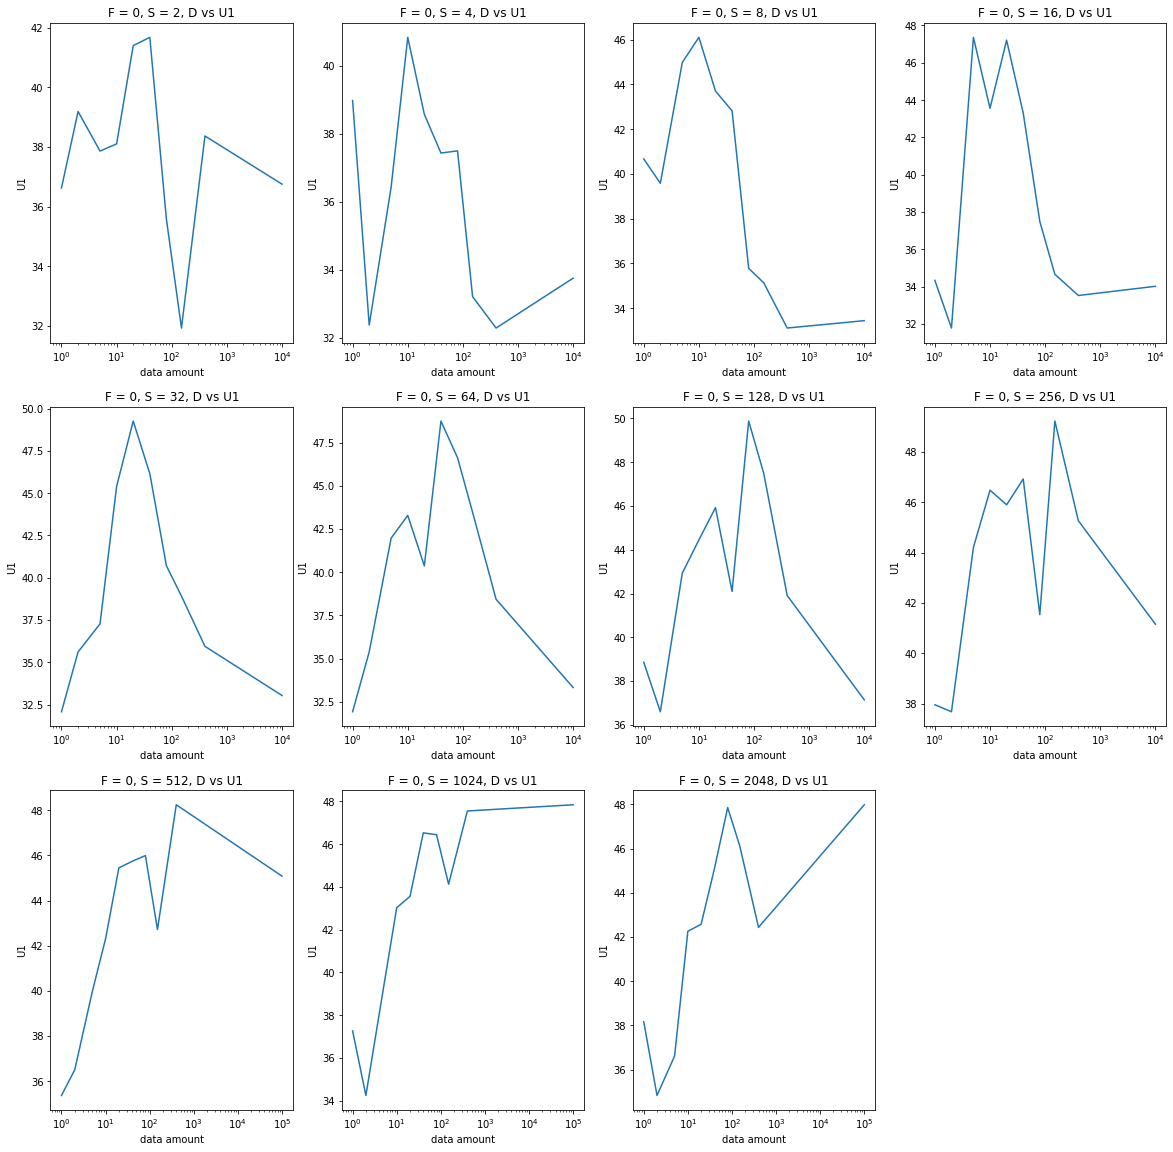

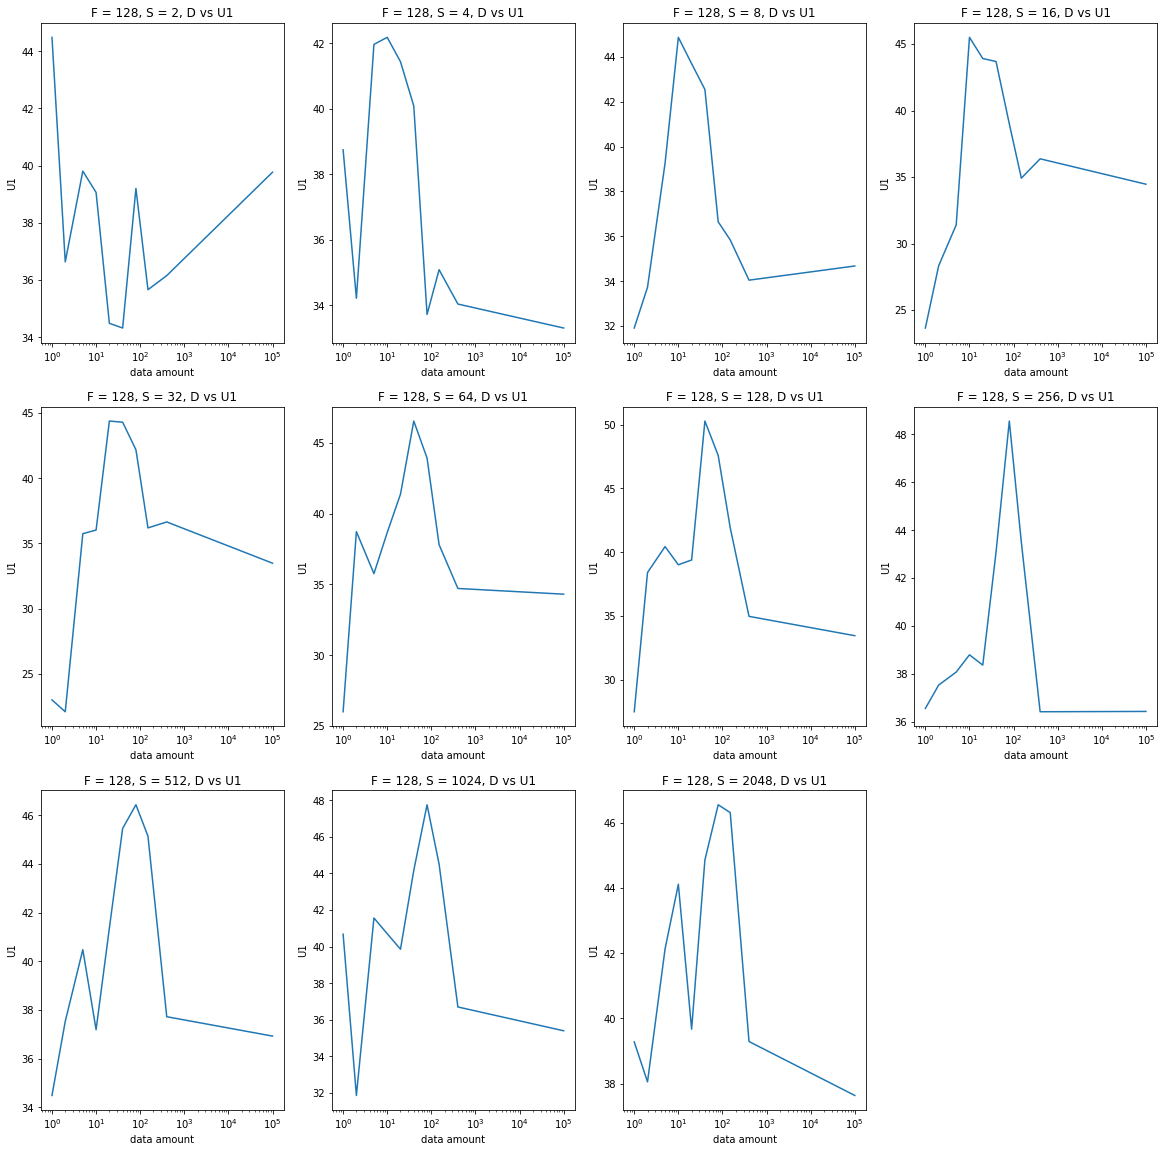

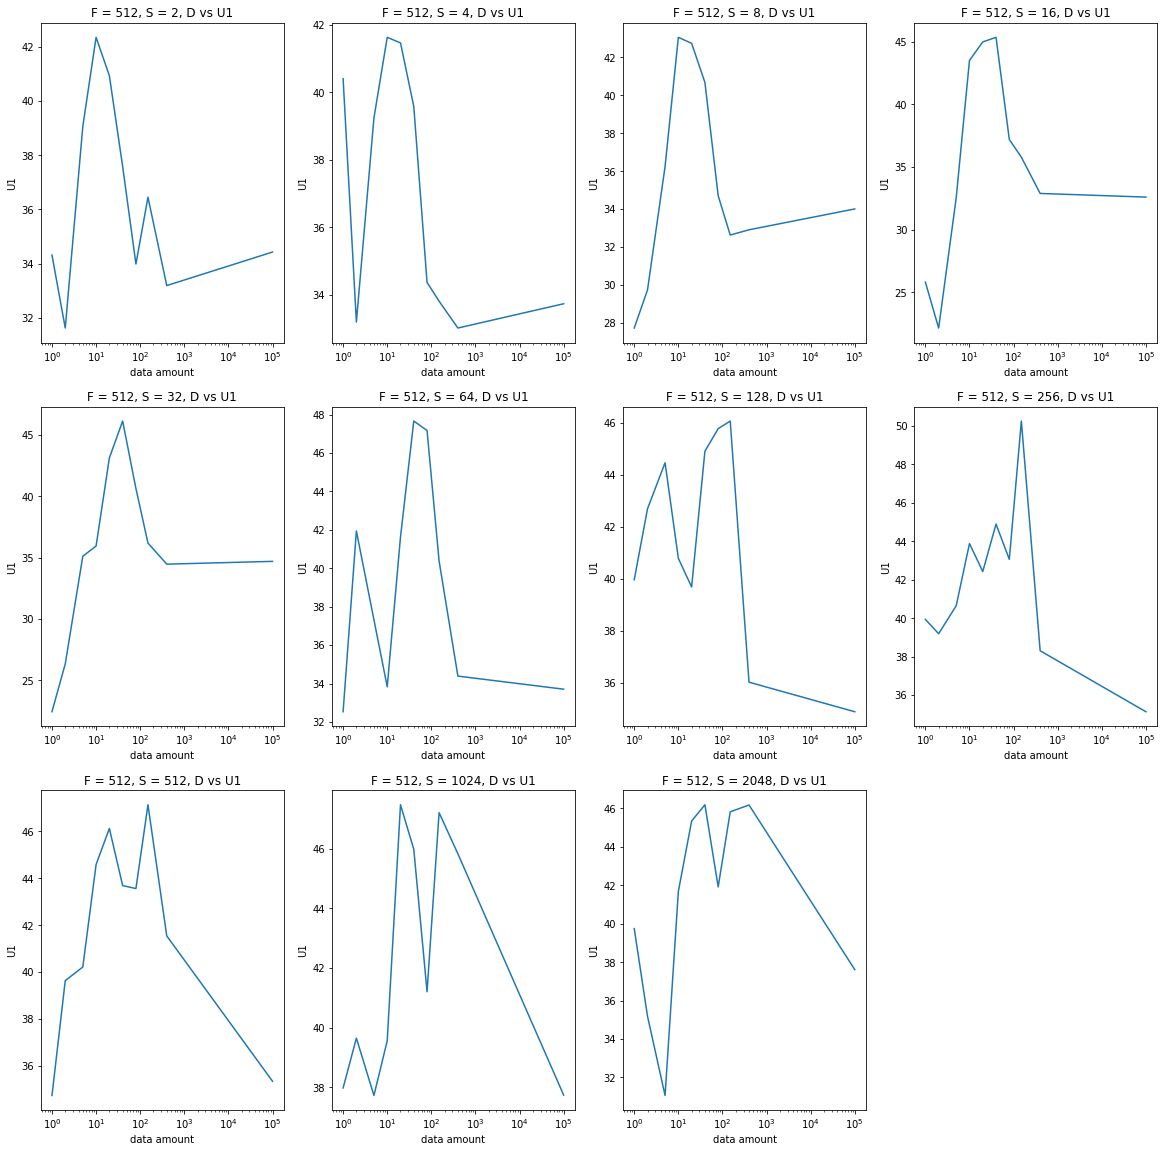

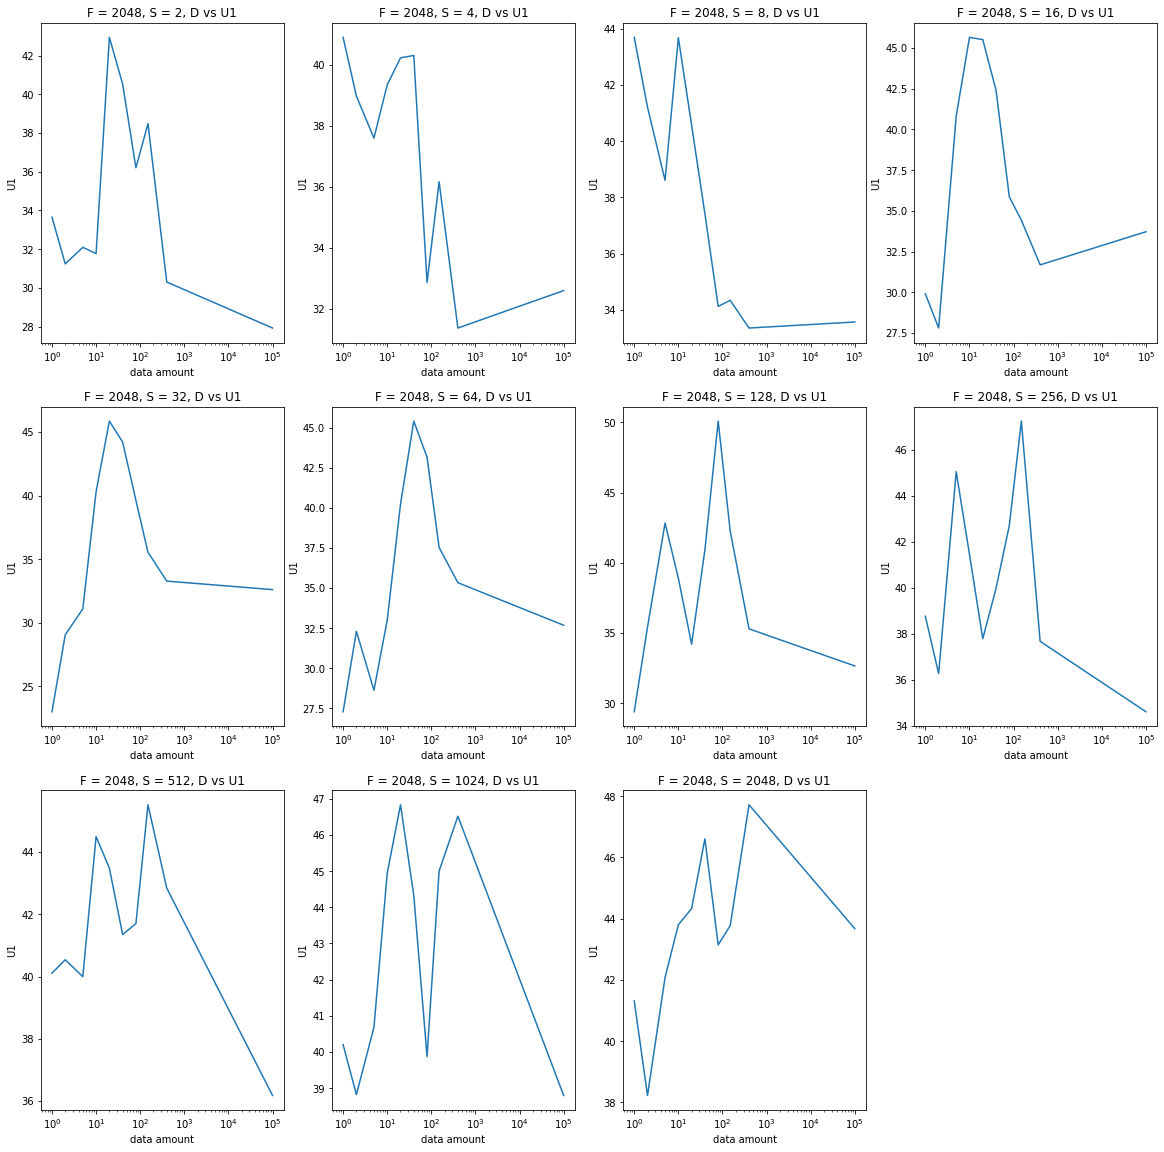

In [3]:
for f in [0, 128, 512, 2048]:
    plt.figure(figsize=(20,20))
    i = 0
    for s in [2,4,8,16,32,64,128,256,512,1024,2048]:
        plt.subplot(3,4,i+1)
        plt.grid(False)
        plt.title("F = {}, S = {}, D vs U1".format(f,s))
        plt.xscale("log")
        plt.xlabel("data amount")
        plt.ylabel("U1")
        rows = df.loc[(df["F"] == f) & (df["S"] == s)]
        plt.plot(rows['D'], rows['U1'])
        i+=1

## Data amount vs Seen prec1

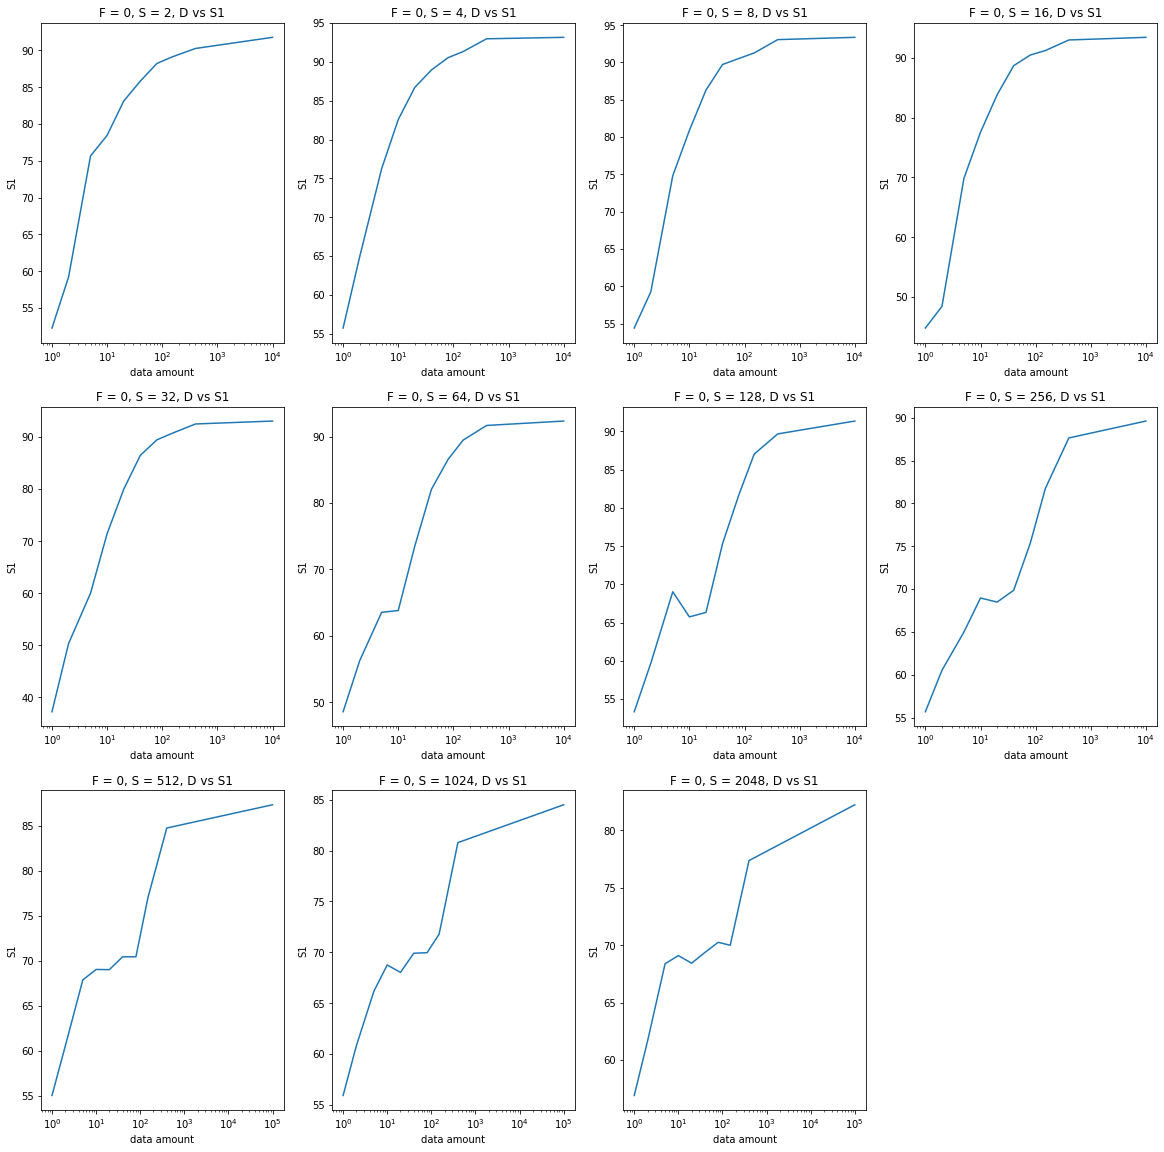

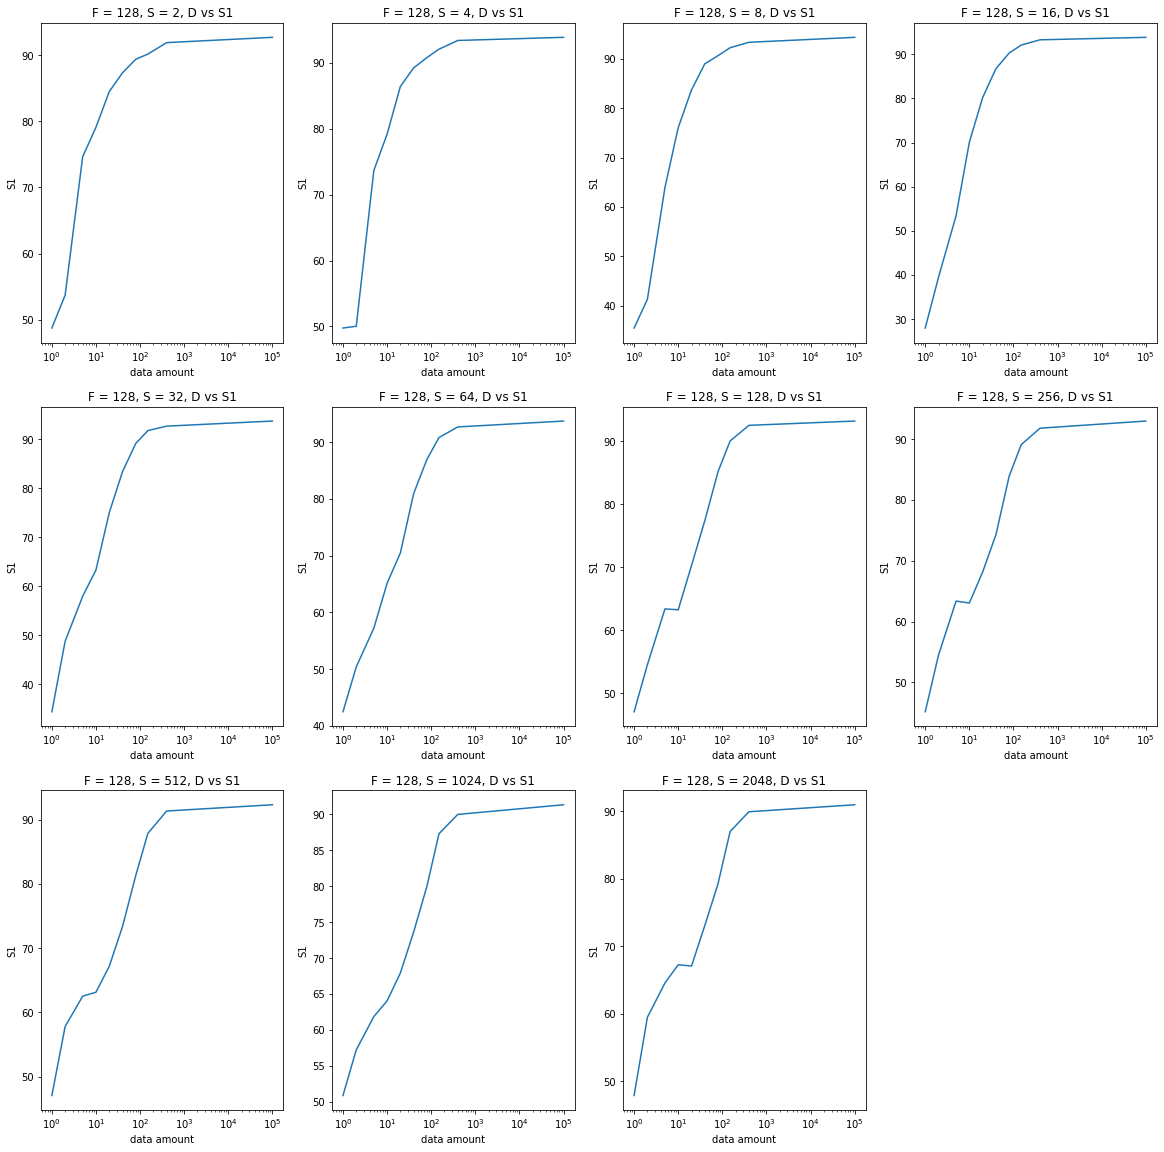

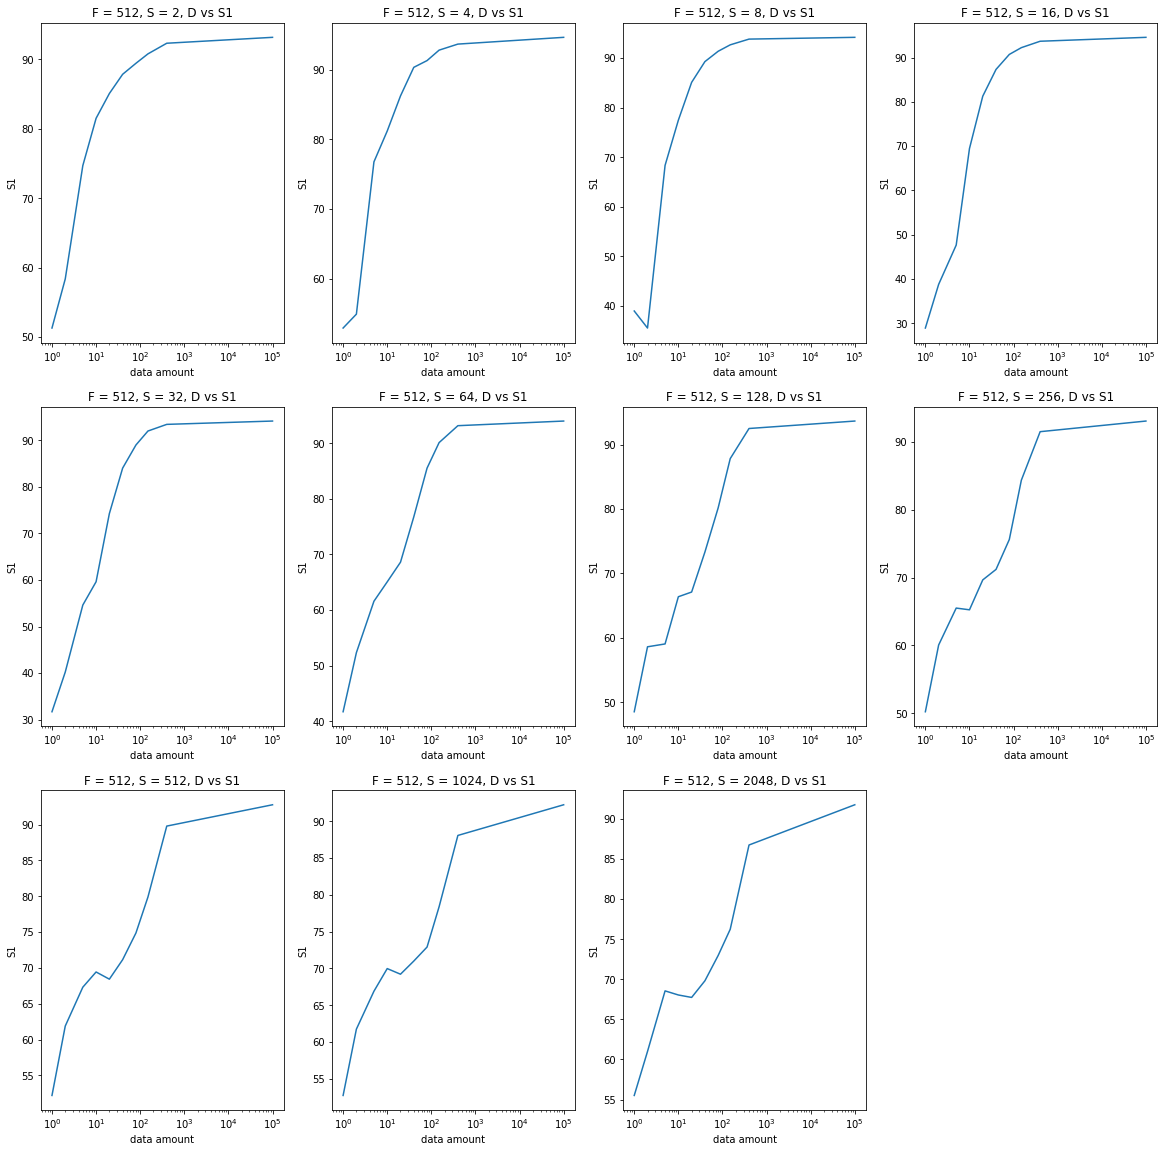

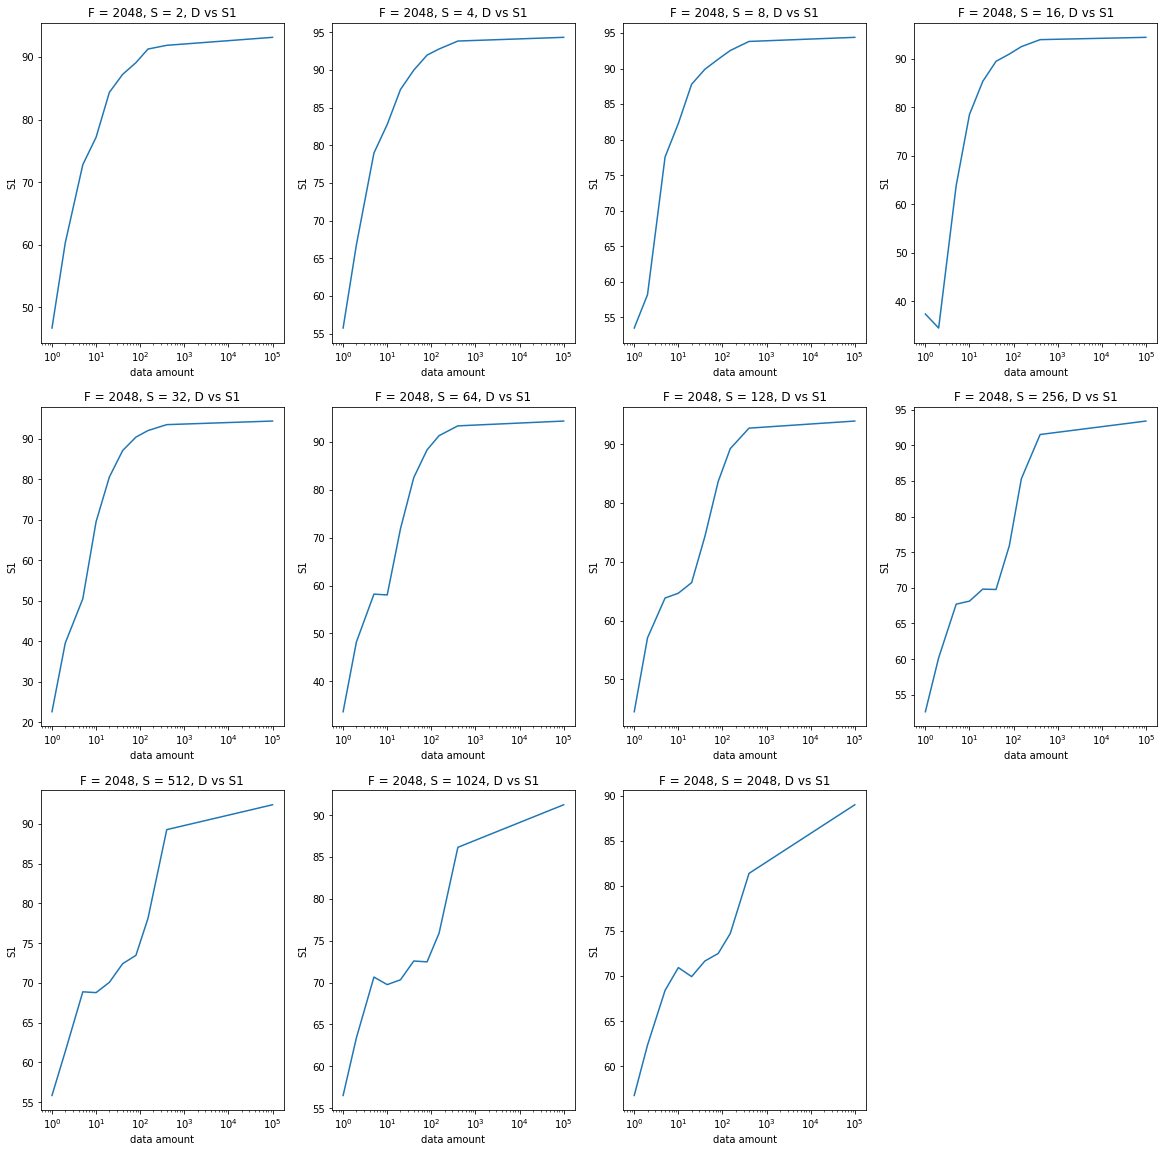

In [4]:
for f in [0, 128, 512, 2048]:
    plt.figure(figsize=(20,20))
    i = 0
    for s in [2,4,8,16,32,64,128,256,512,1024,2048]:
        plt.subplot(3,4,i+1)
        plt.grid(False)
        plt.title("F = {}, S = {}, D vs S1".format(f,s))
        plt.xscale("log")
        plt.xlabel("data amount")
        plt.ylabel("S1")
        rows = df.loc[(df["F"] == f) & (df["S"] == s)]
        plt.plot(rows['D'], rows['S1'])
        i+=1

## Data amount vs Harmonic

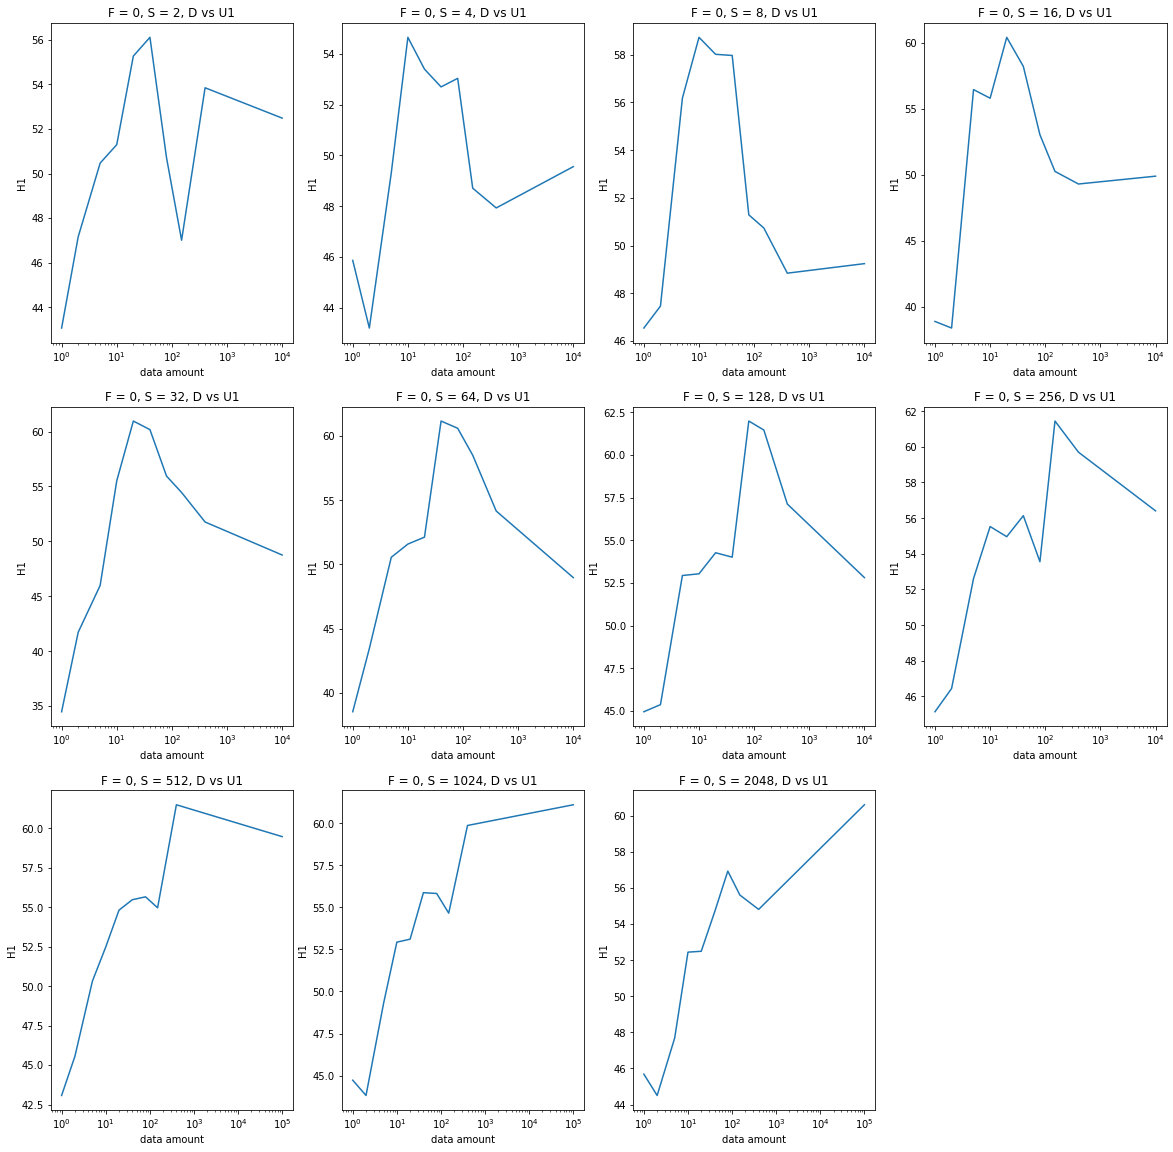

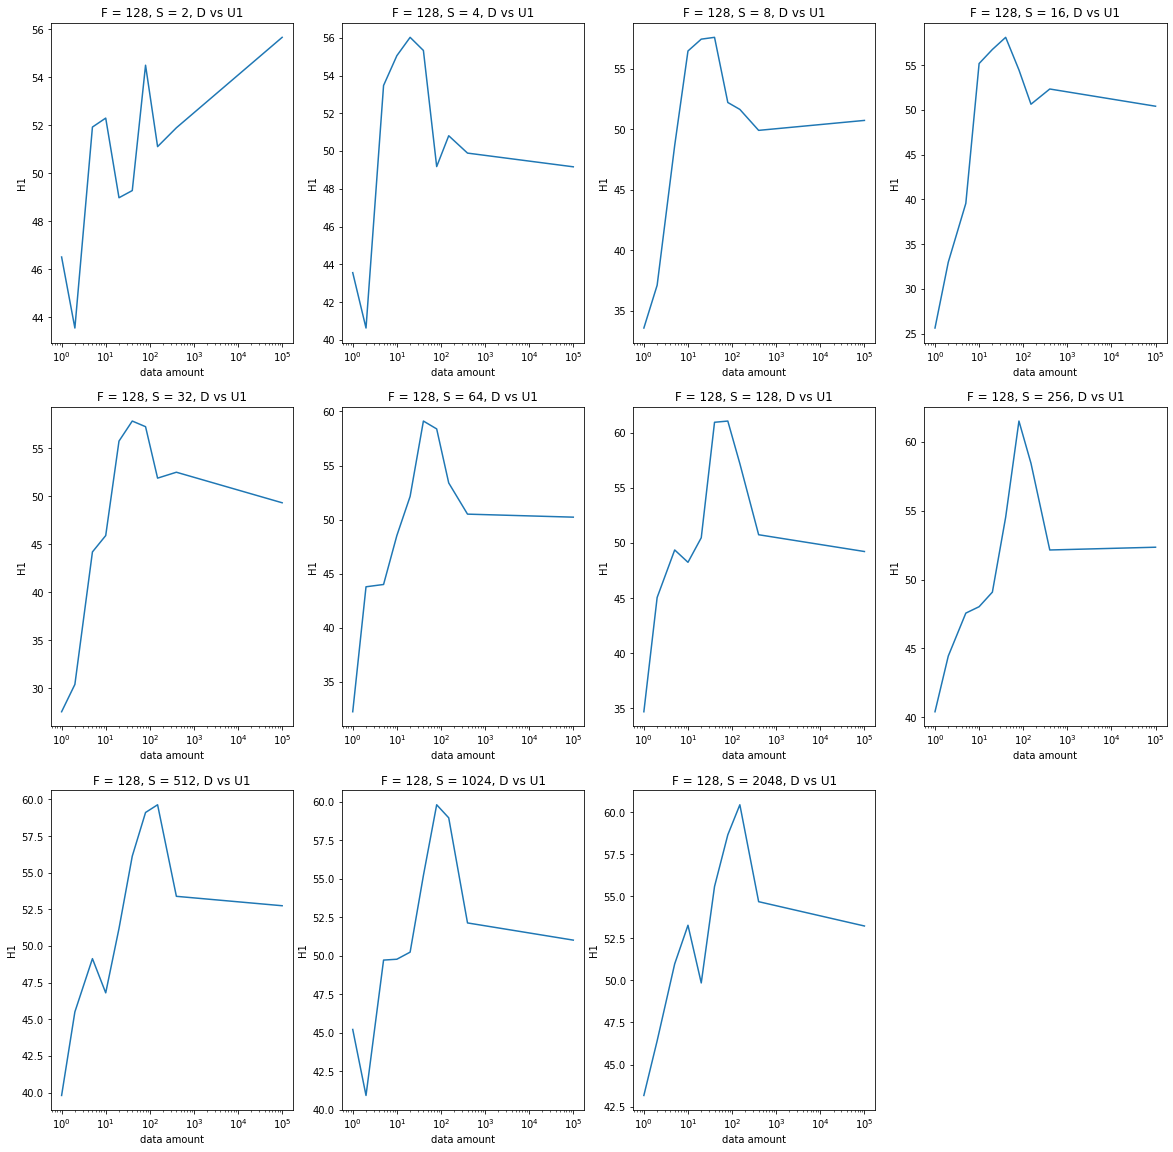

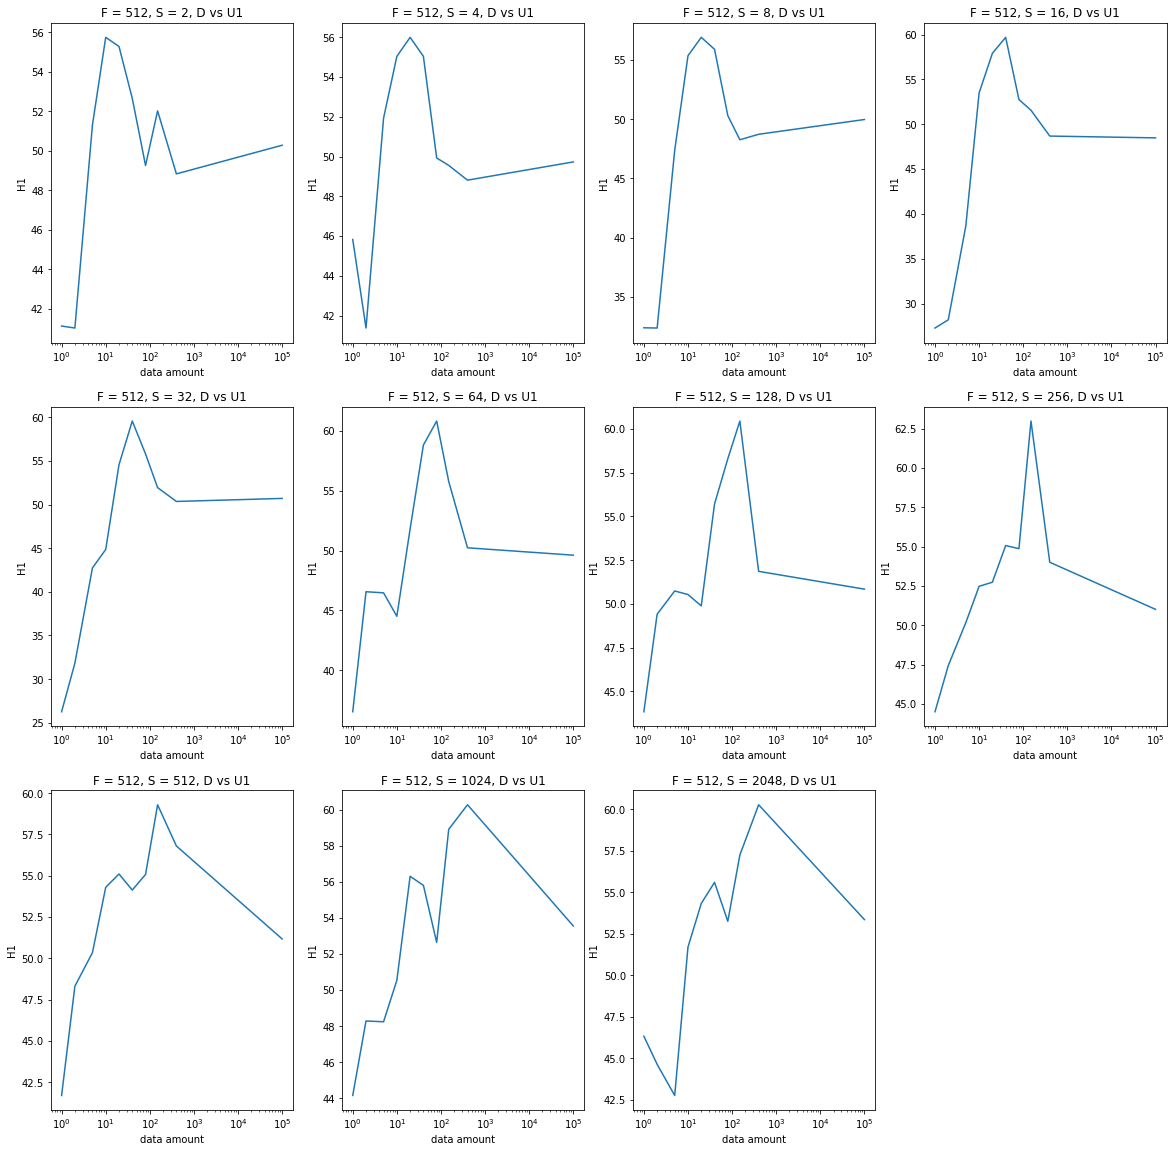

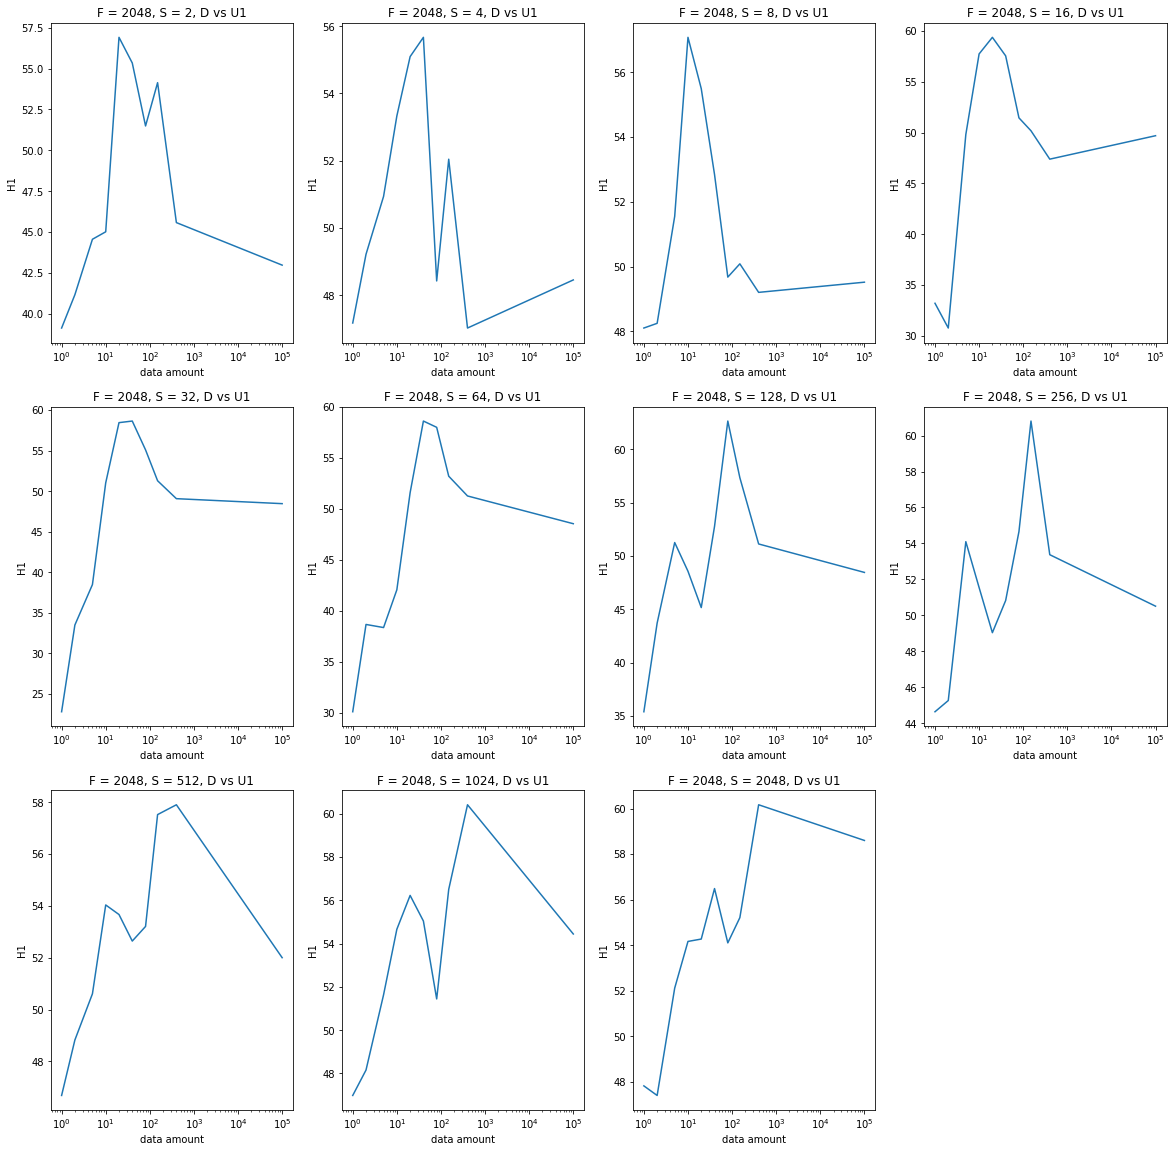

In [82]:
for f in [0, 128, 512, 2048]:
    plt.figure(figsize=(20,20))
    i = 0
    for s in [2,4,8,16,32,64,128,256,512,1024,2048]:
        plt.subplot(3,4,i+1)
        plt.grid(False)
        plt.title("F = {}, S = {}, D vs H1".format(f,s))
        plt.xscale("log")
        plt.xlabel("data amount")
        plt.ylabel("H1")
        rows = df.loc[(df["F"] == f) & (df["S"] == s)]
        plt.plot(rows['D'], rows['H1'])
        i+=1

## Number of embedded size vs unseen precision

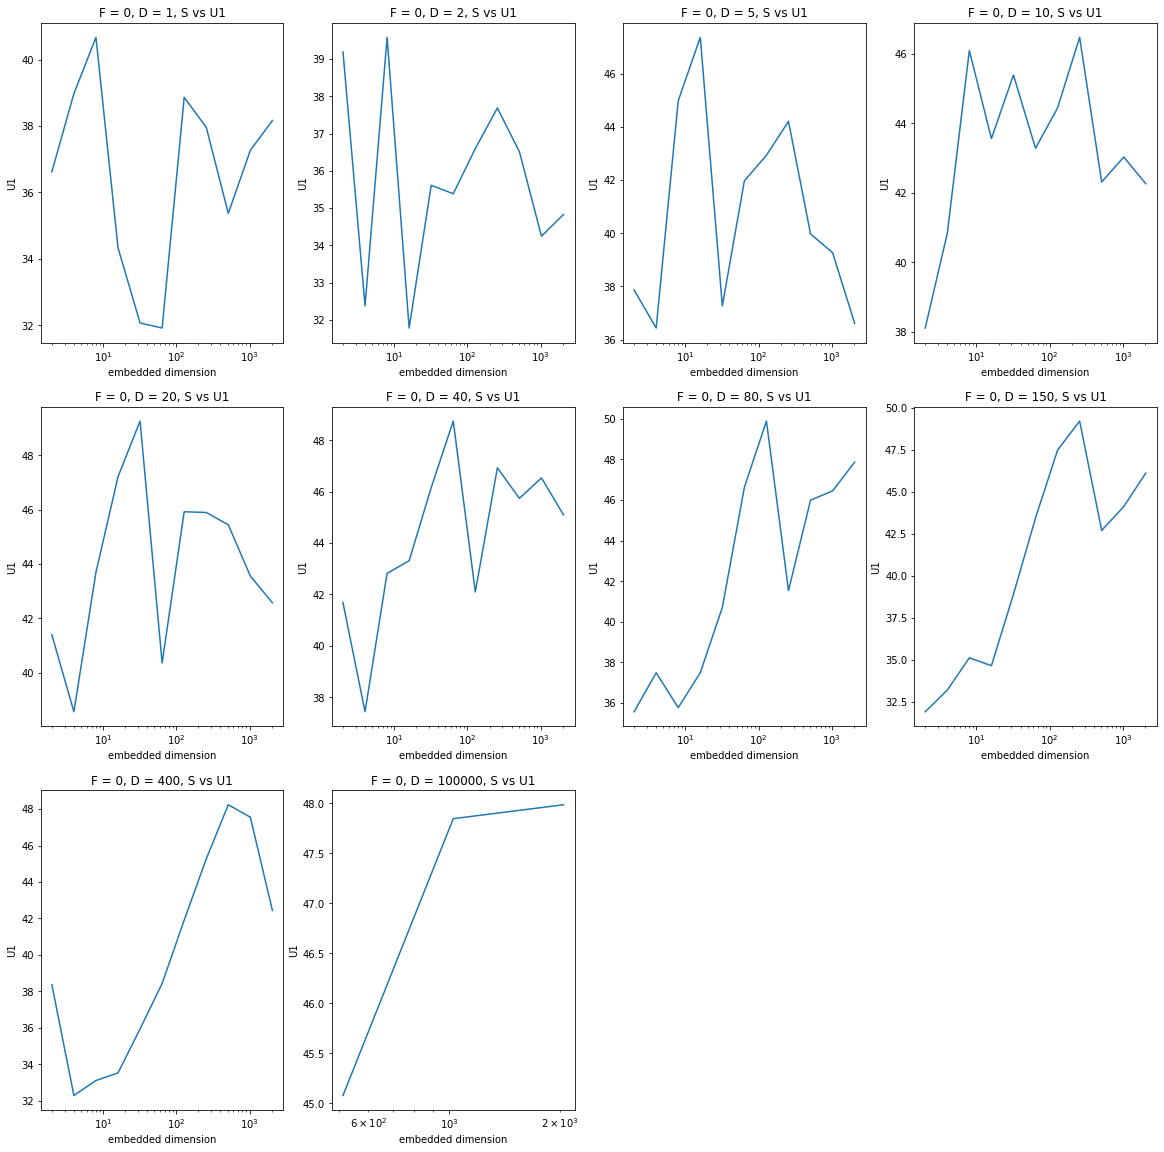

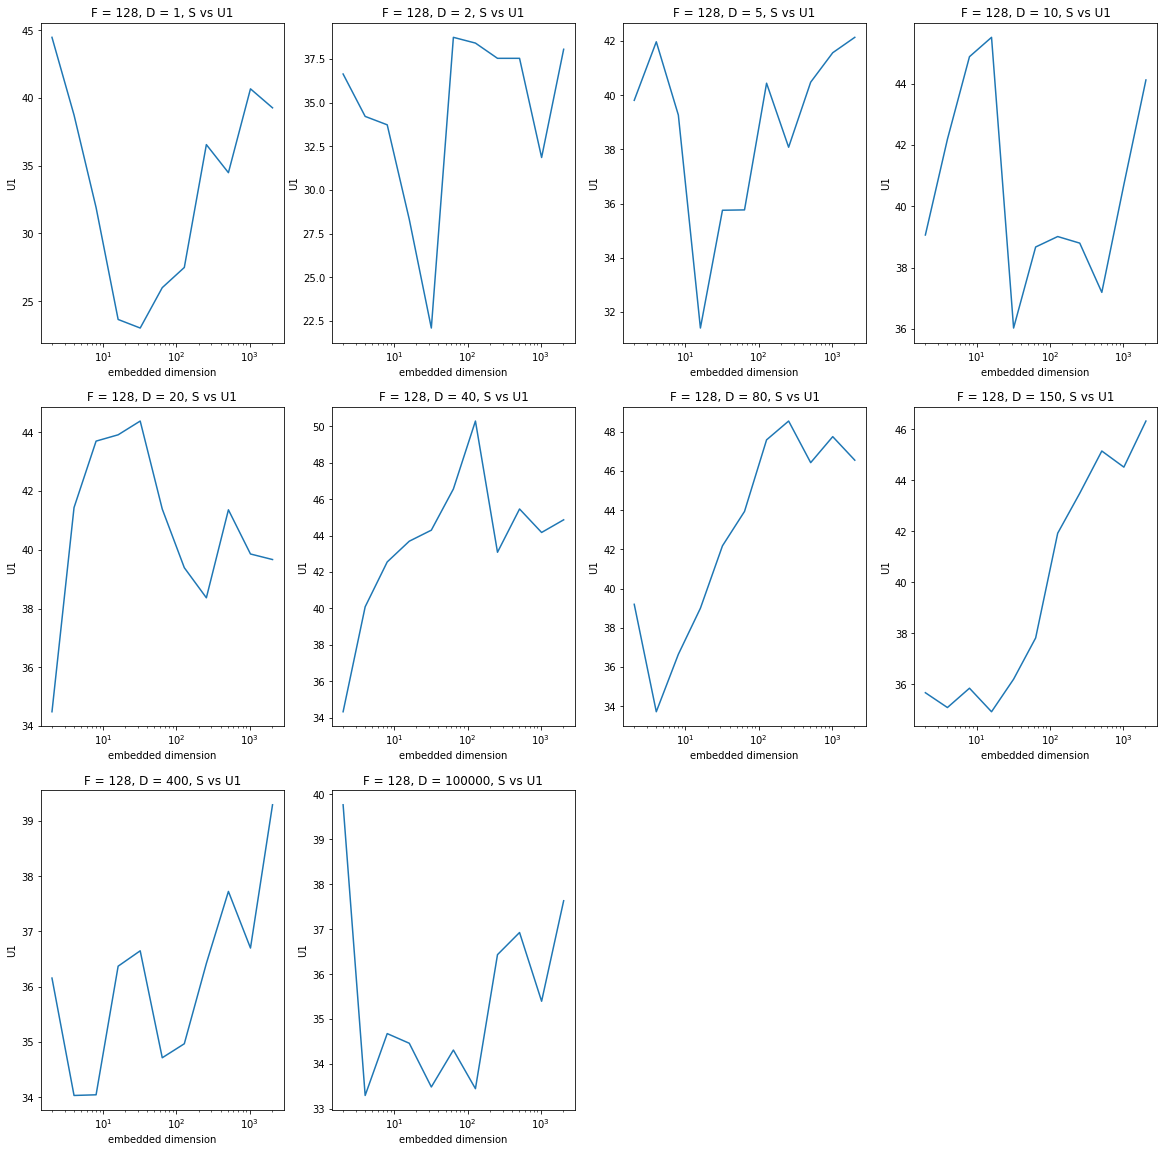

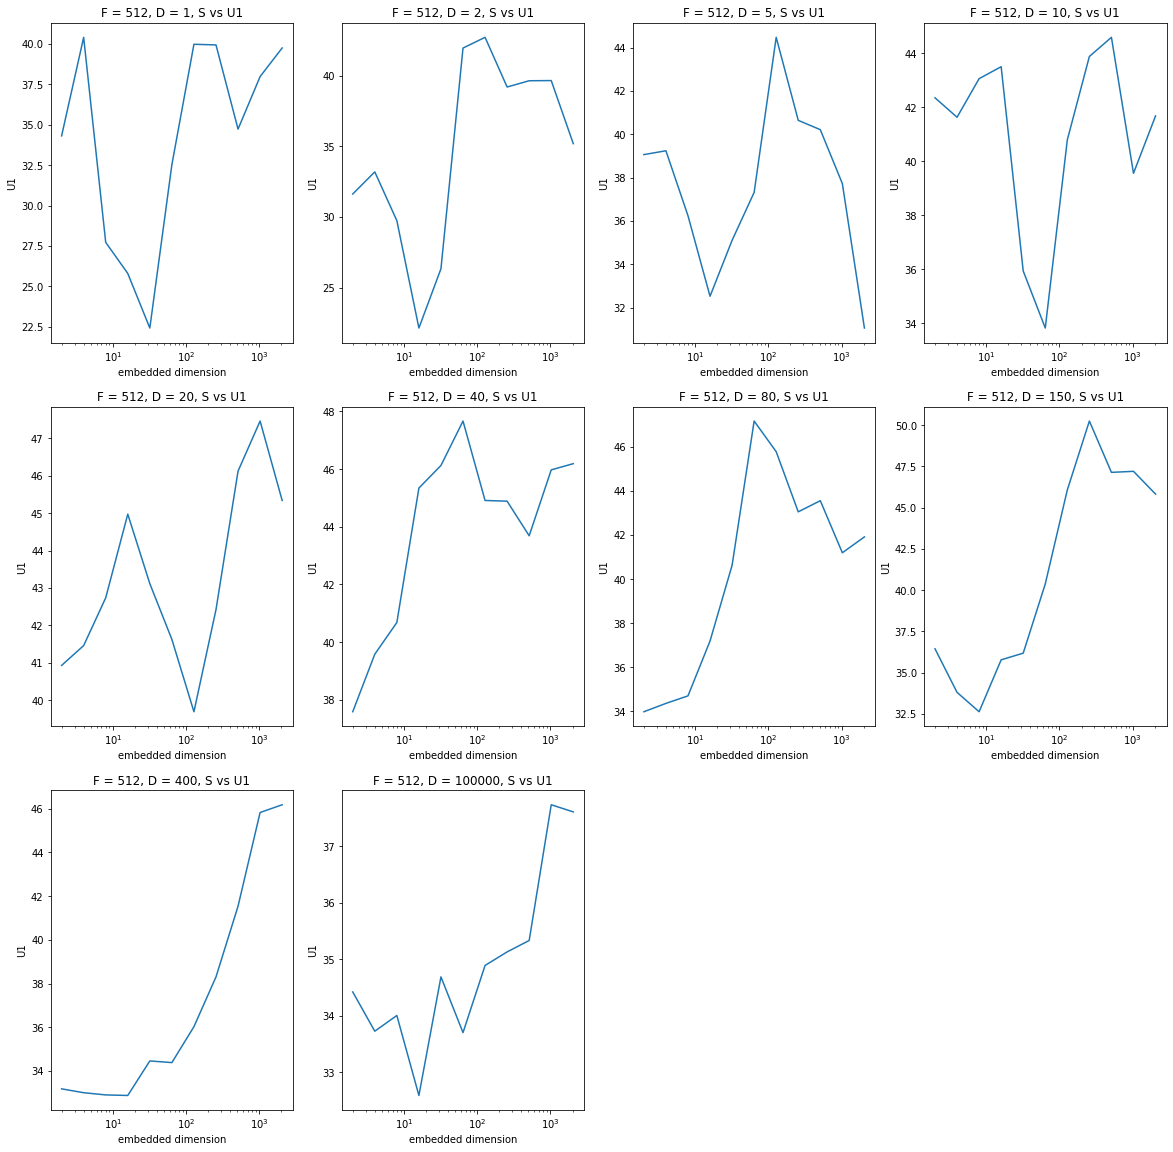

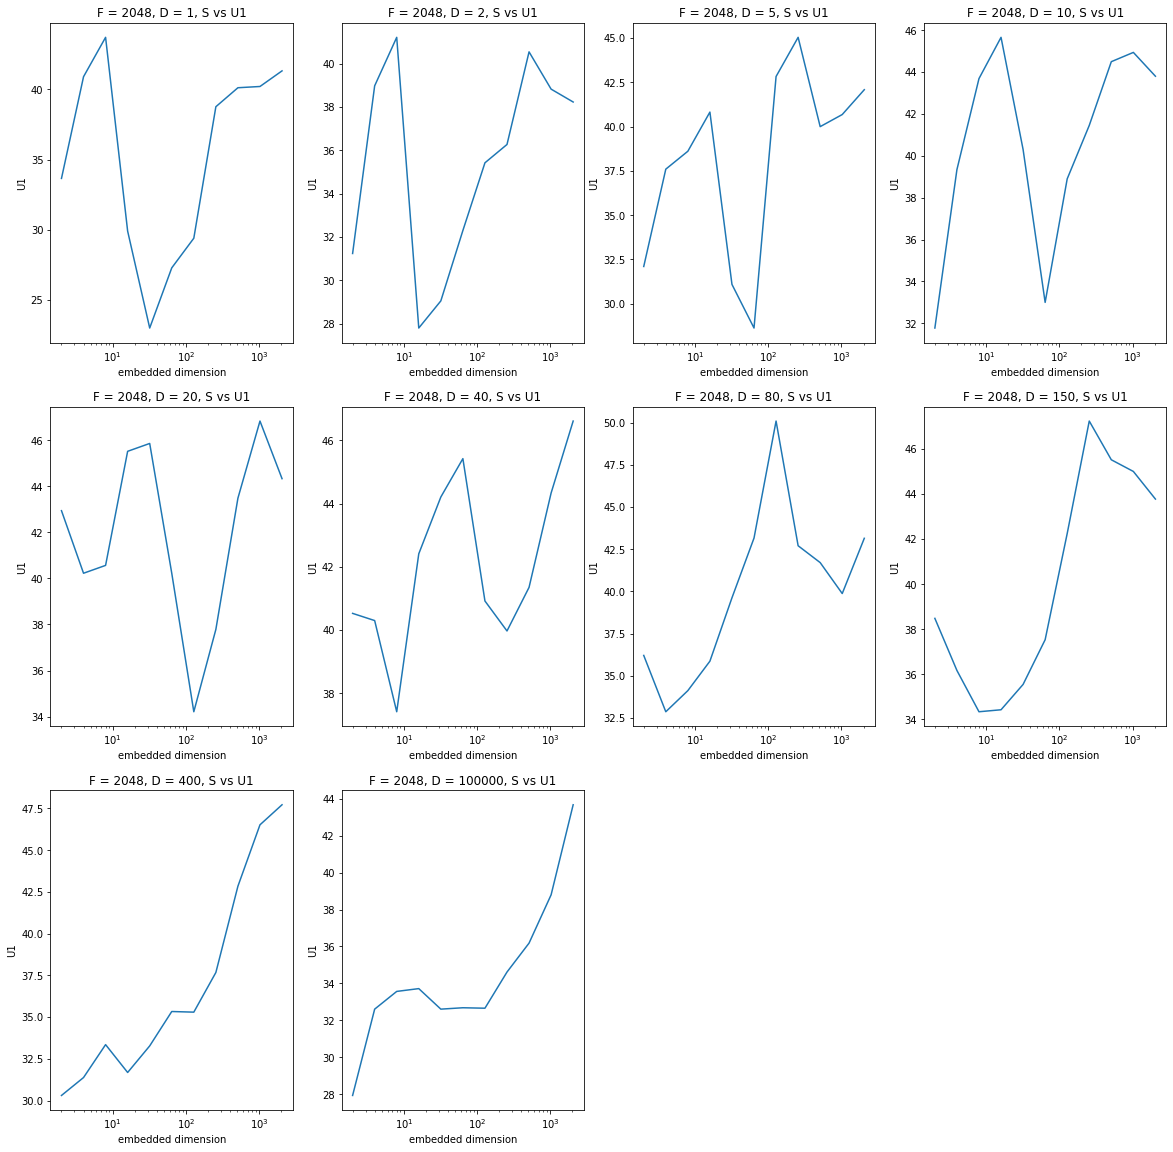

In [86]:
for f in [0, 128, 512, 2048]:
    plt.figure(figsize=(20,20))
    i = 0
    for d in [1,2,5,10,20,40,80,150,400,100000]:
        plt.subplot(3,4,i+1)
        plt.grid(False)
        plt.title("F = {}, D = {}, S vs U1".format(f,d))
        plt.xscale("log")
        plt.xlabel("embedded dimension")
        plt.ylabel("U1")
        rows = df.loc[(df["F"] == f) & (df["D"] == d)]
        plt.plot(rows['S'], rows['U1'])
        i+=1

## Number of embedded size vs Harmonic

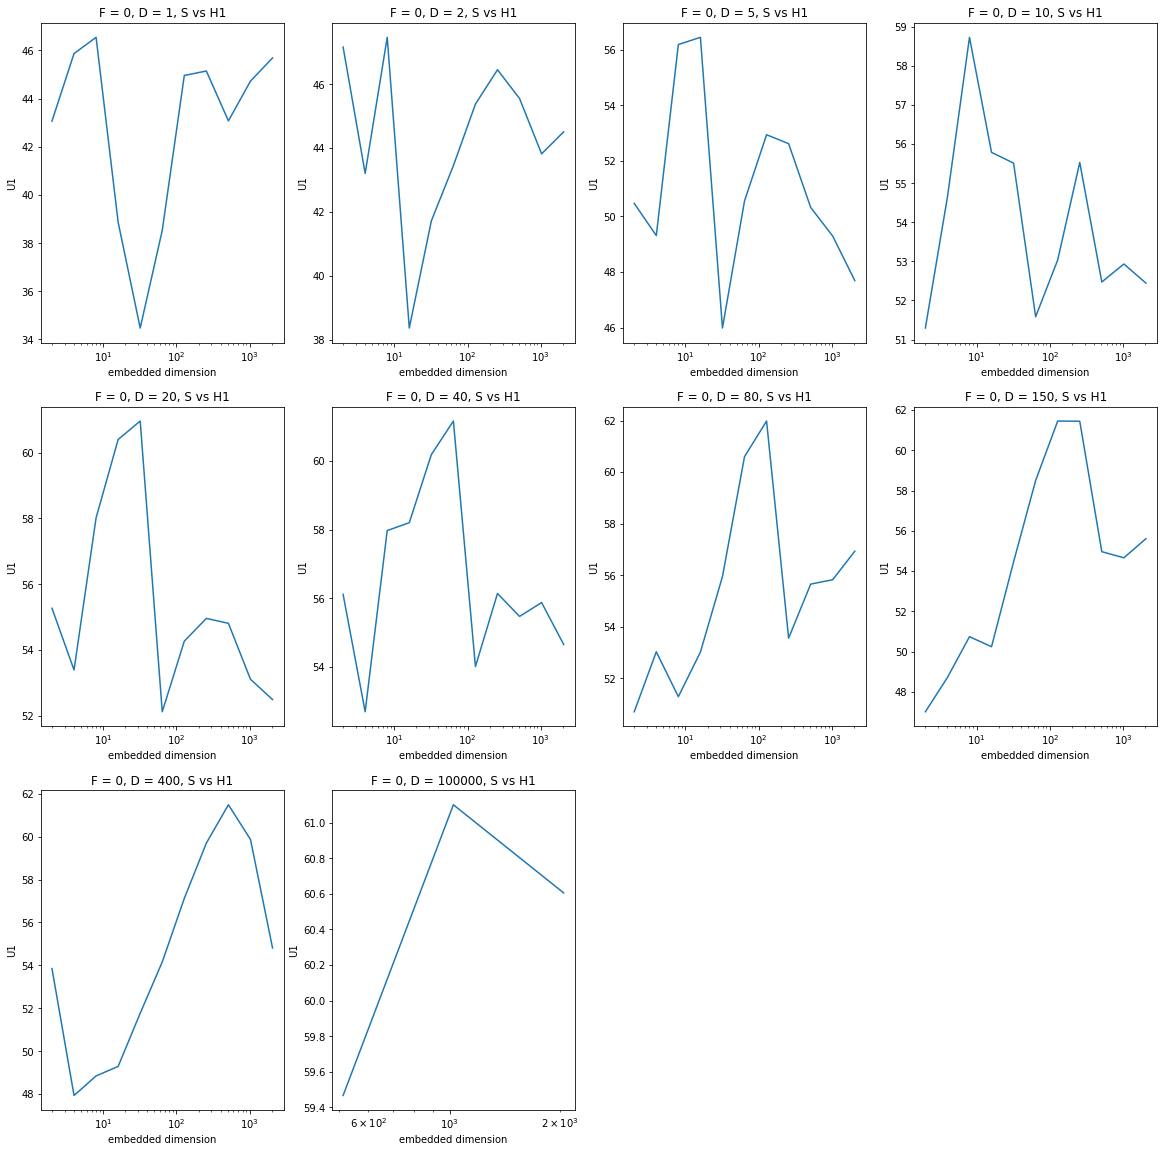

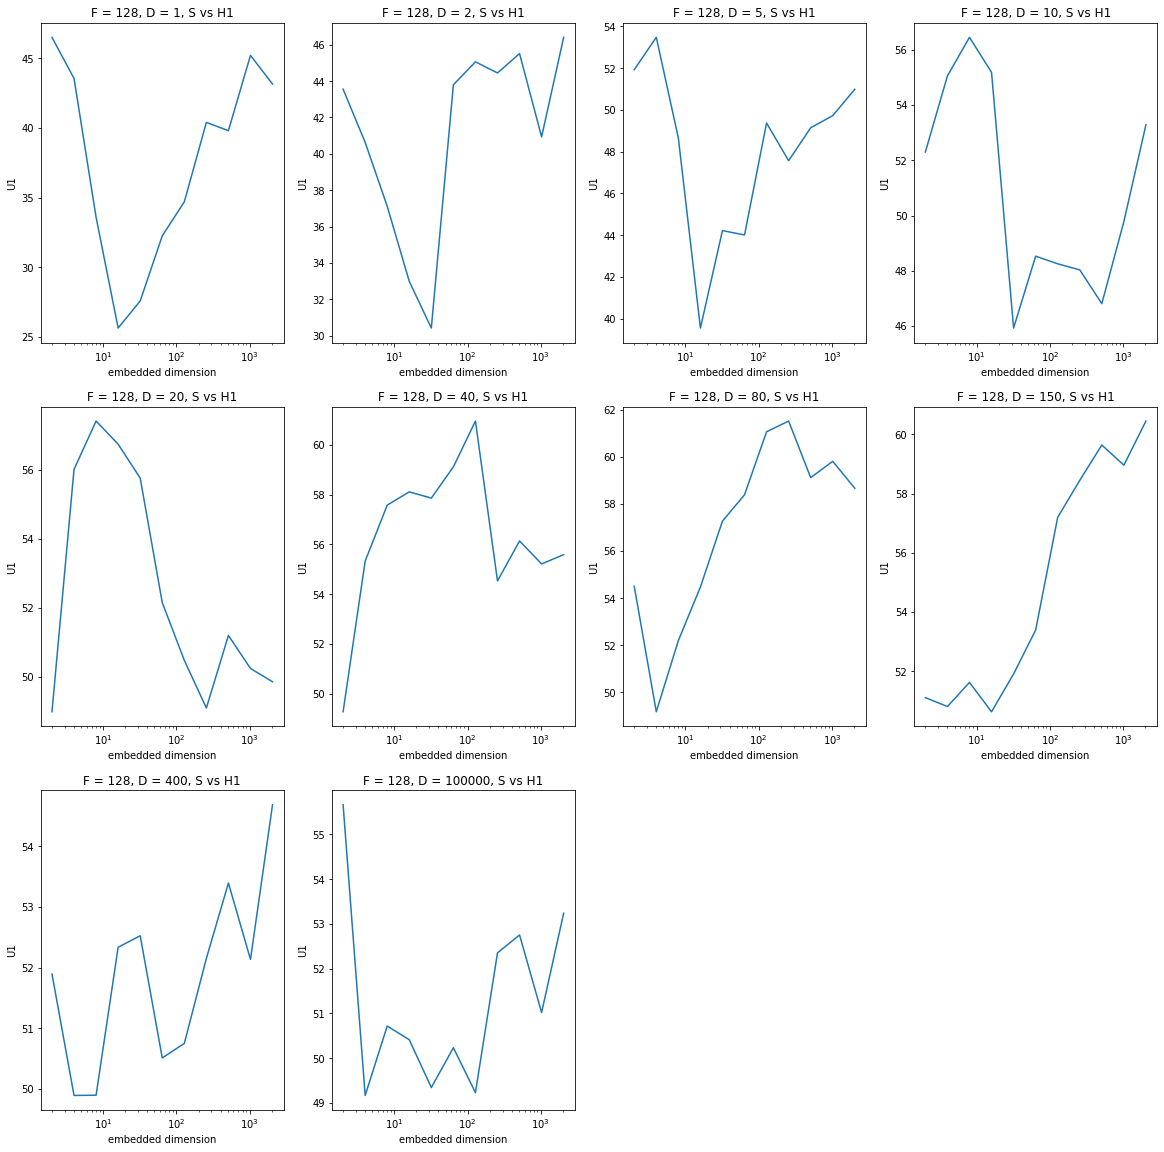

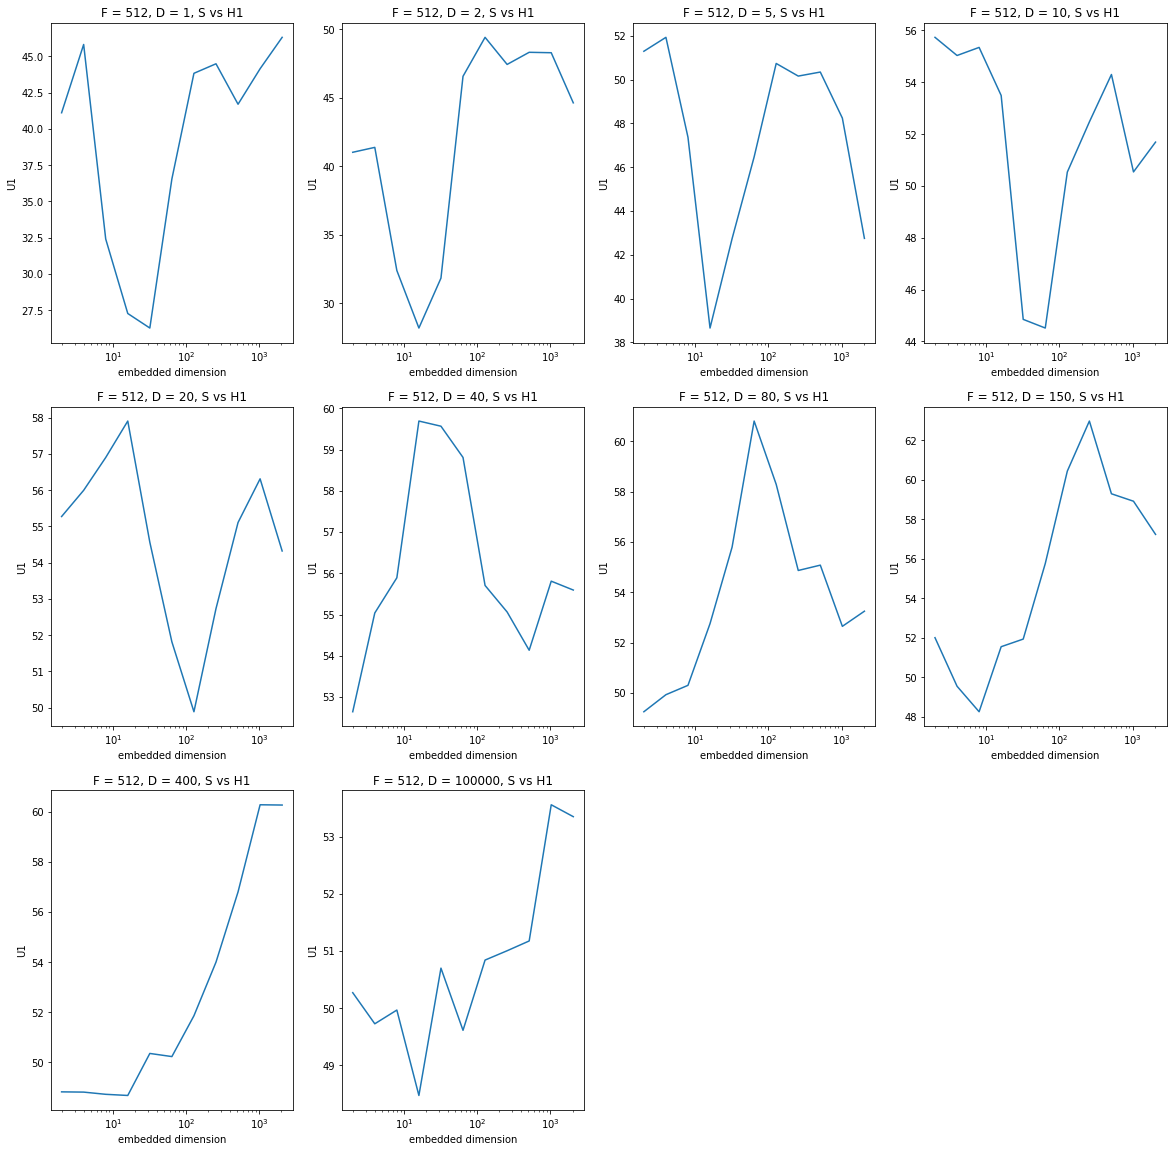

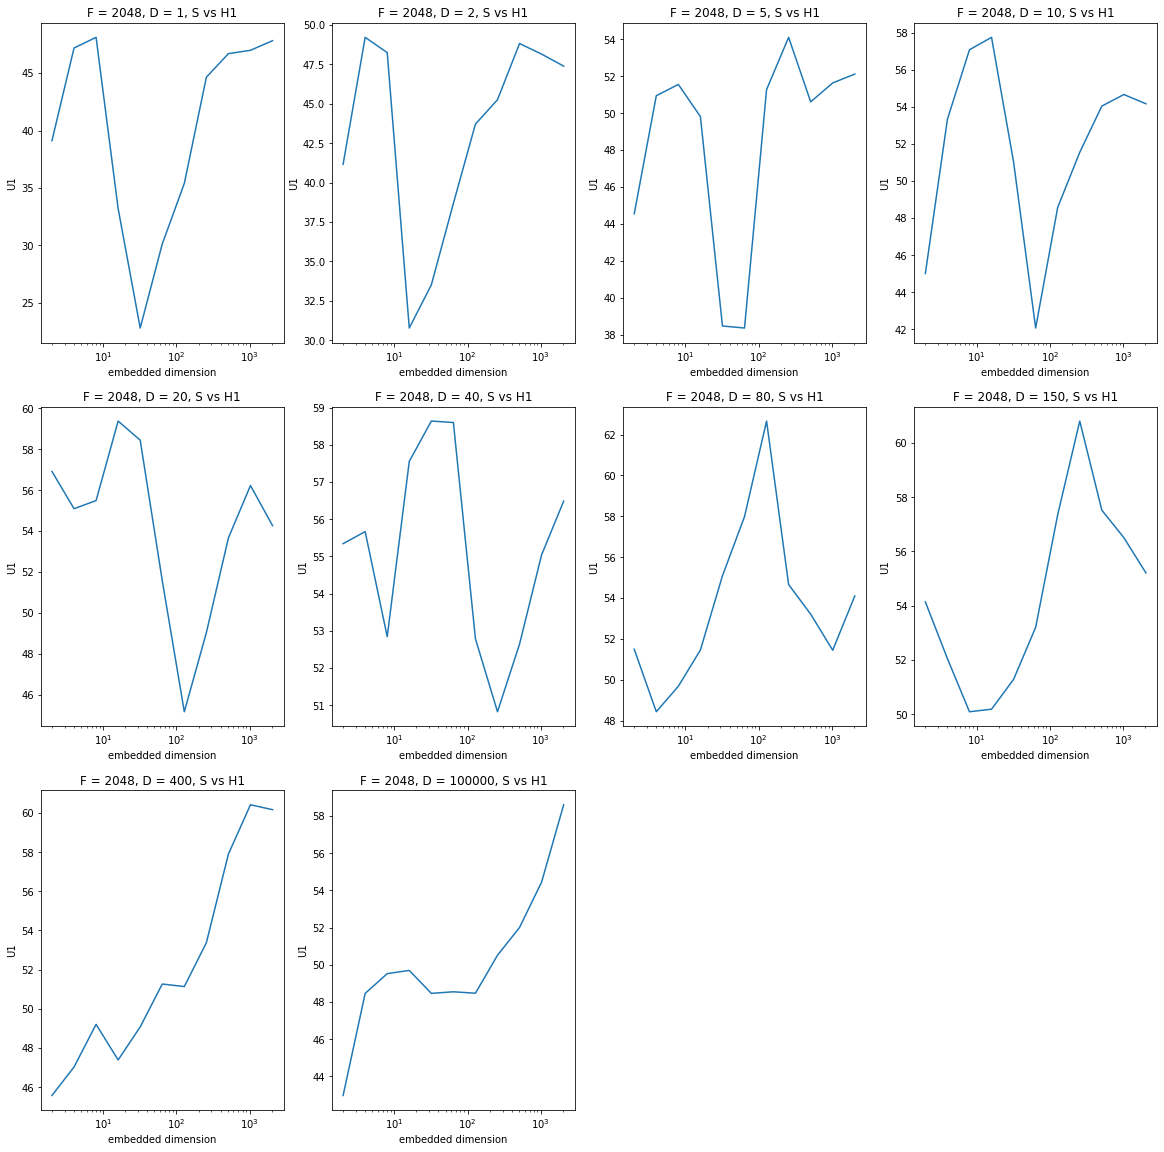

In [87]:
for f in [0, 128, 512, 2048]:
    plt.figure(figsize=(20,20))
    i = 0
    for d in [1,2,5,10,20,40,80,150,400,100000]:
        plt.subplot(3,4,i+1)
        plt.grid(False)
        plt.title("F = {}, D = {}, S vs H1".format(f,d))
        plt.xscale("log")
        plt.xlabel("embedded dimension")
        plt.ylabel("H1")
        rows = df.loc[(df["F"] == f) & (df["D"] == d)]
        plt.plot(rows['S'], rows['H1'])
        i+=1

## Hidden layer size vs Unseen Precision

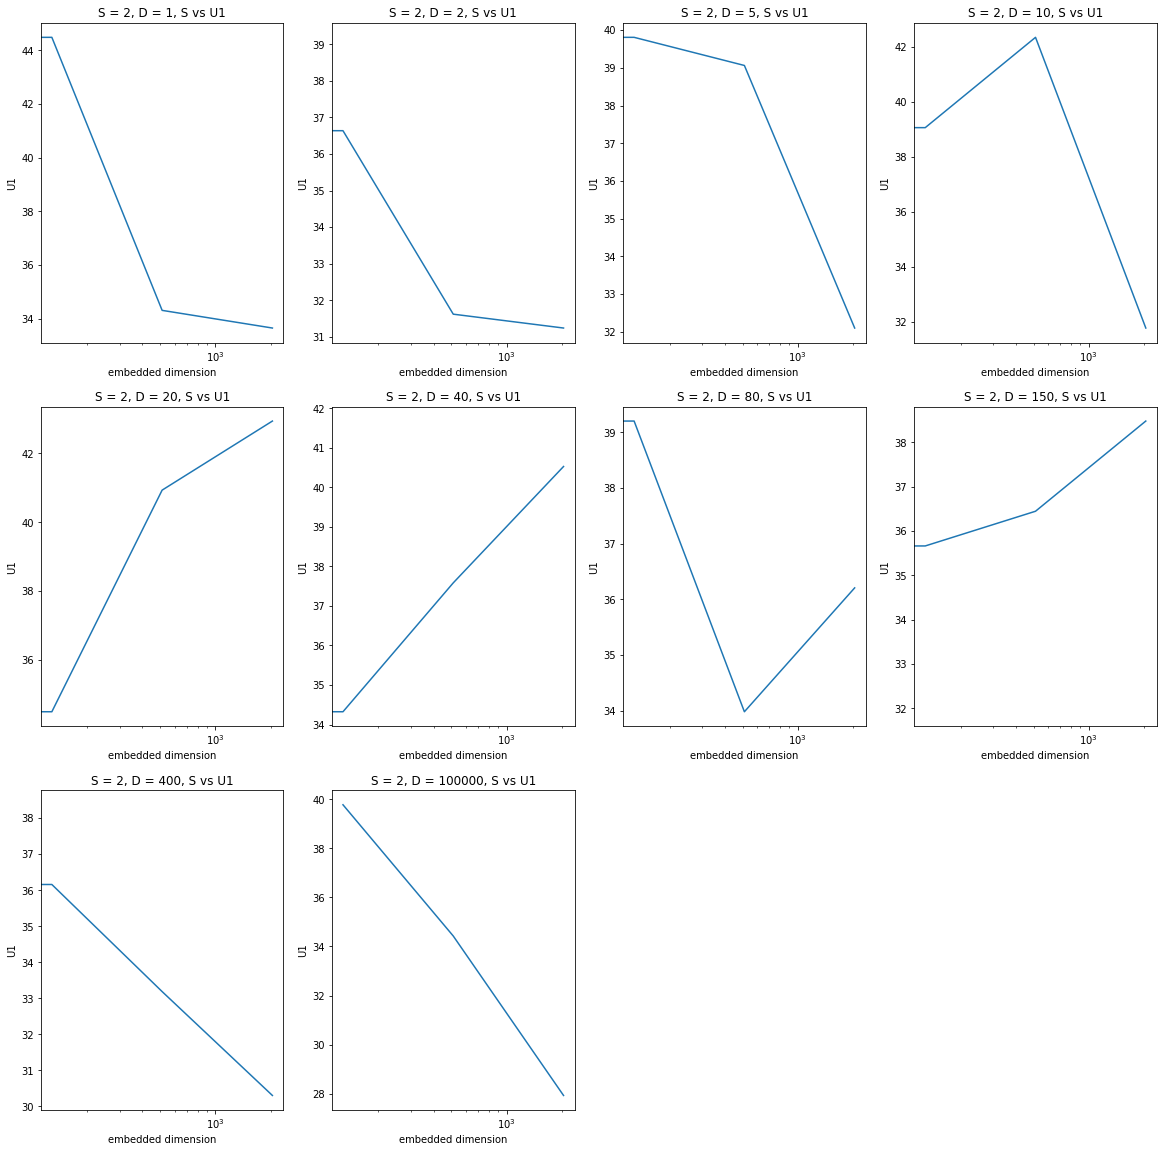

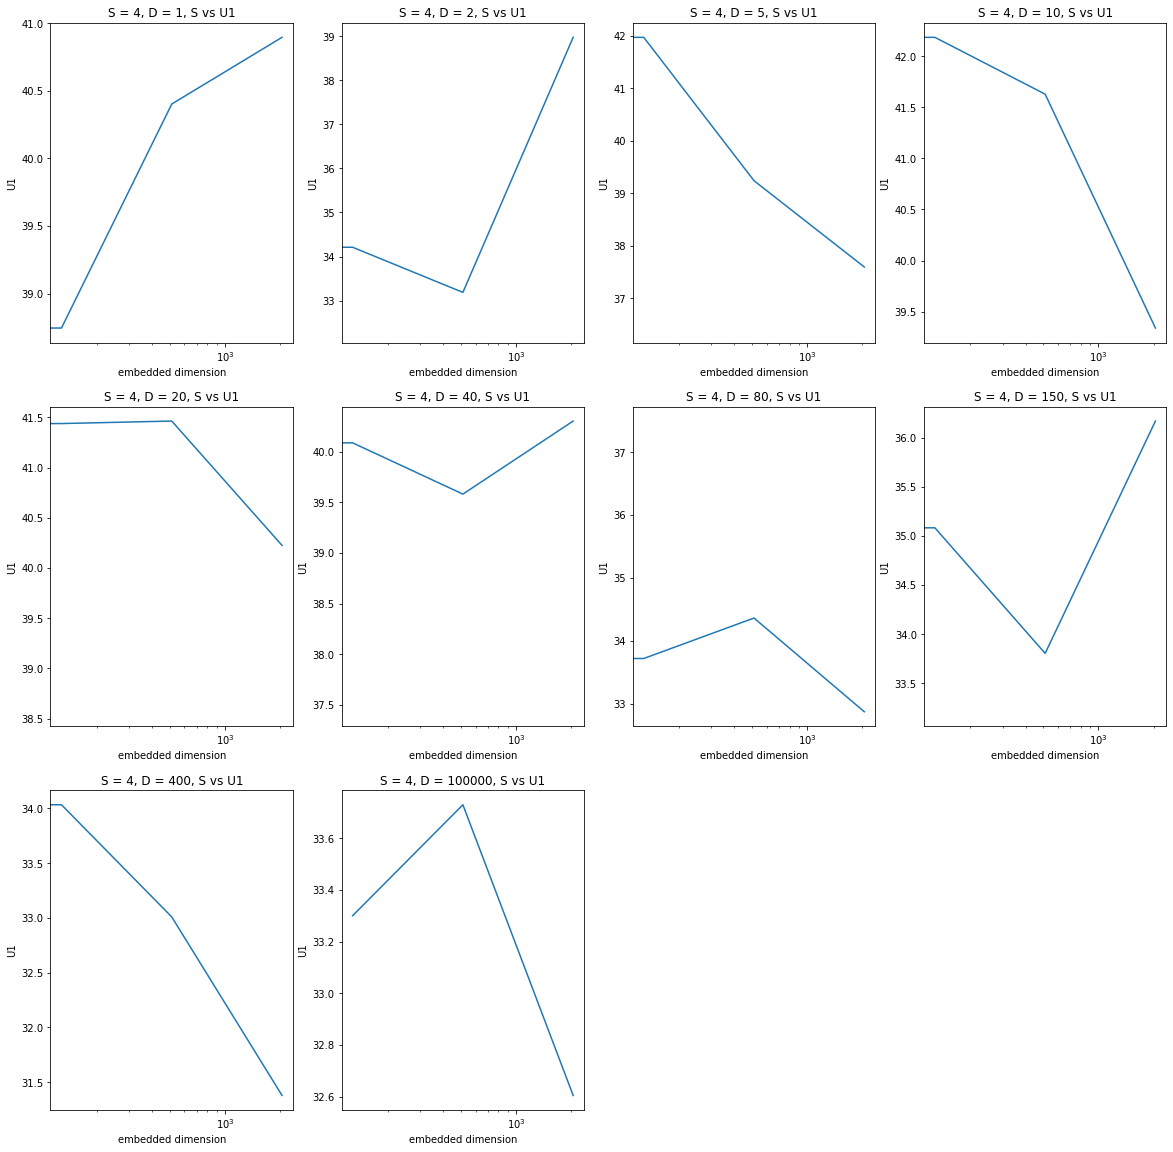

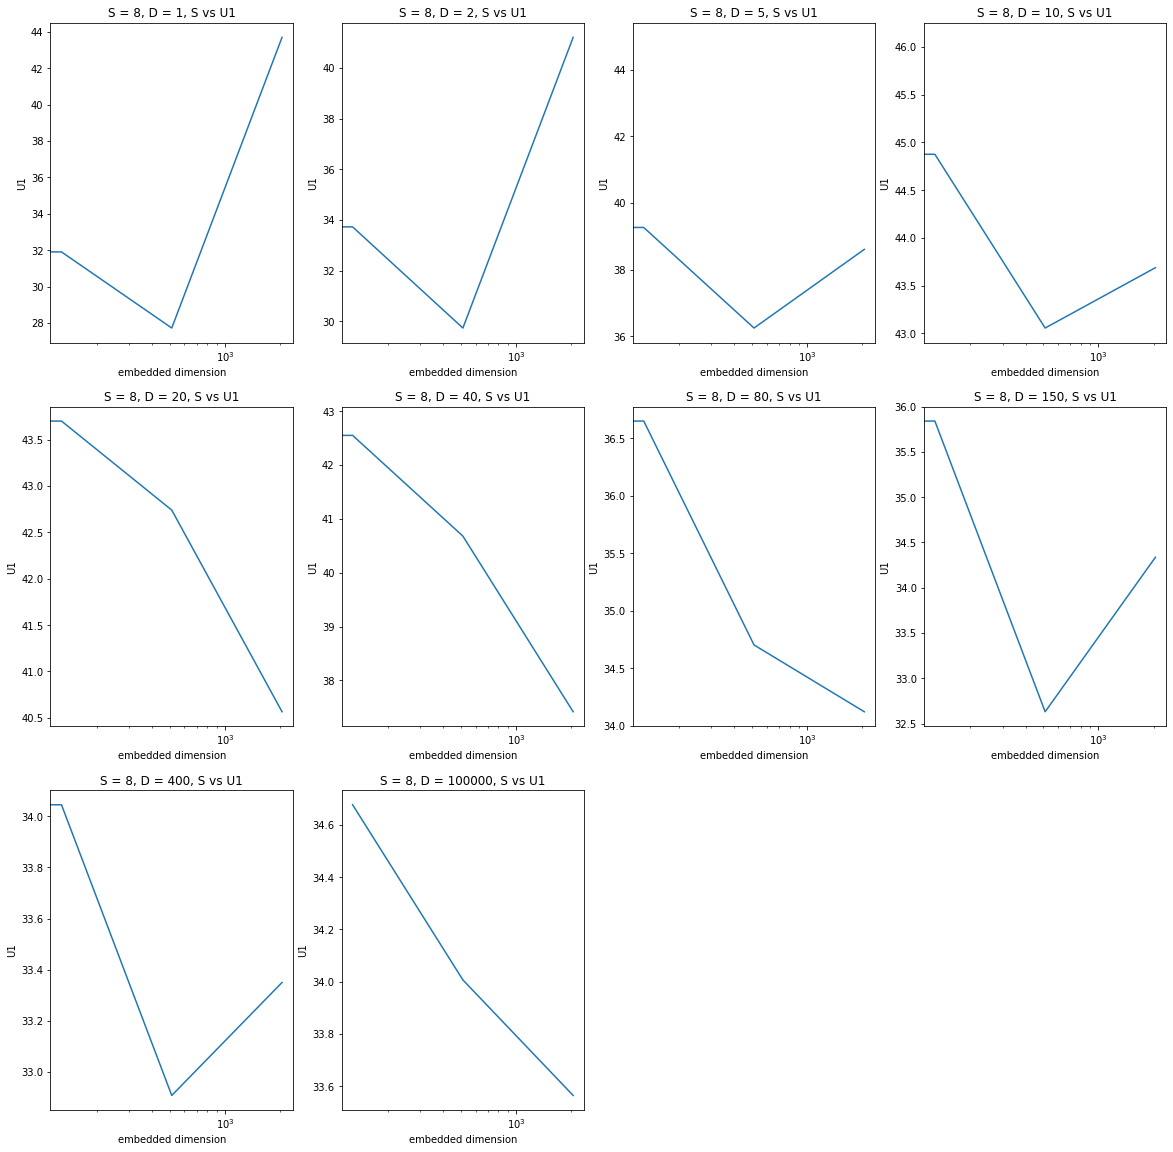

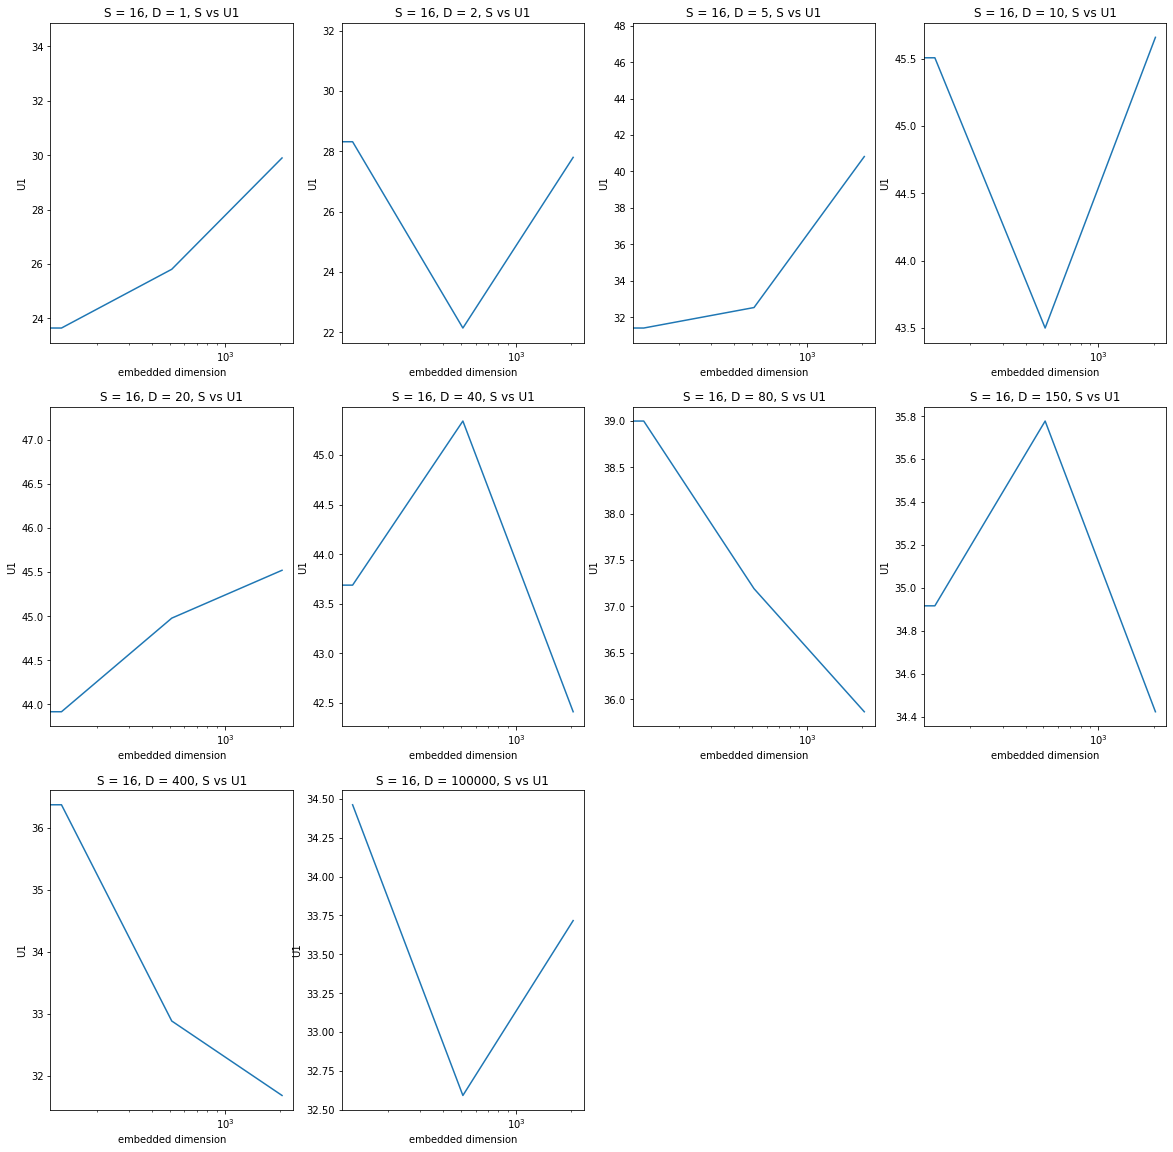

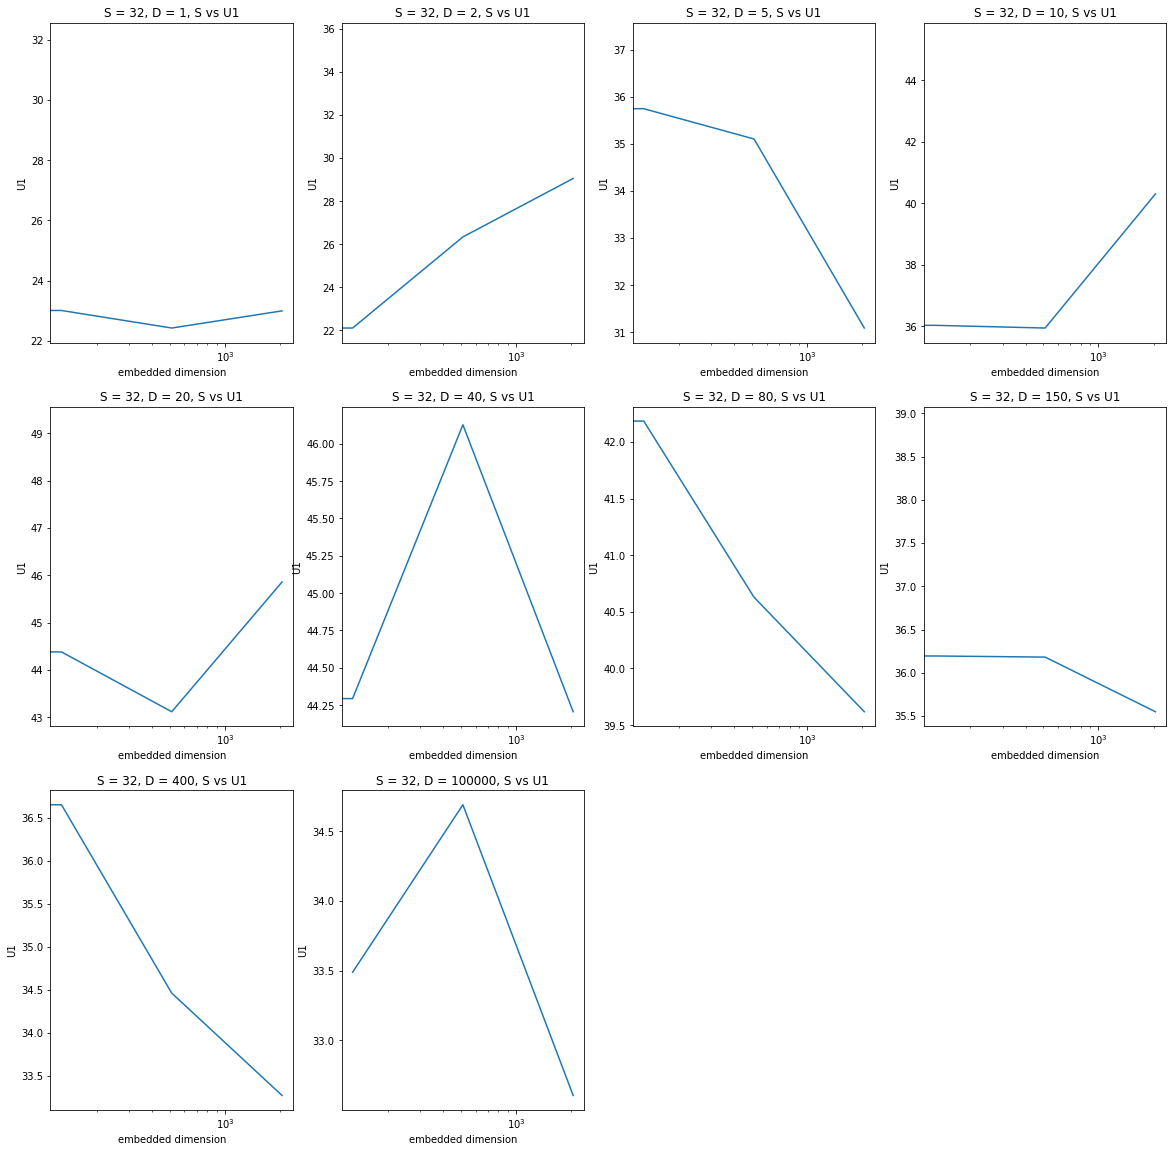

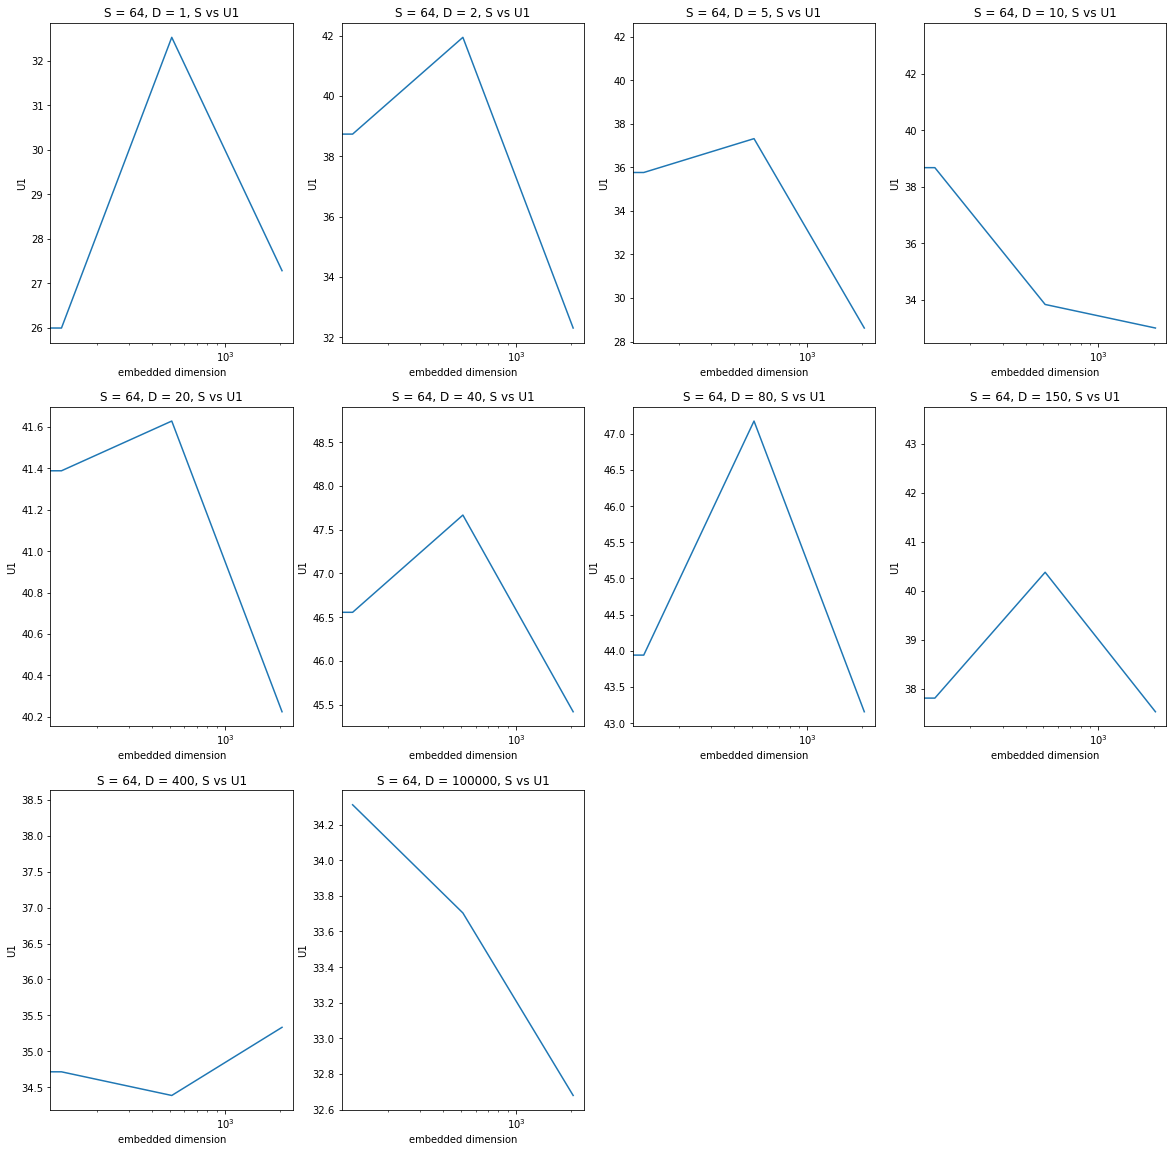

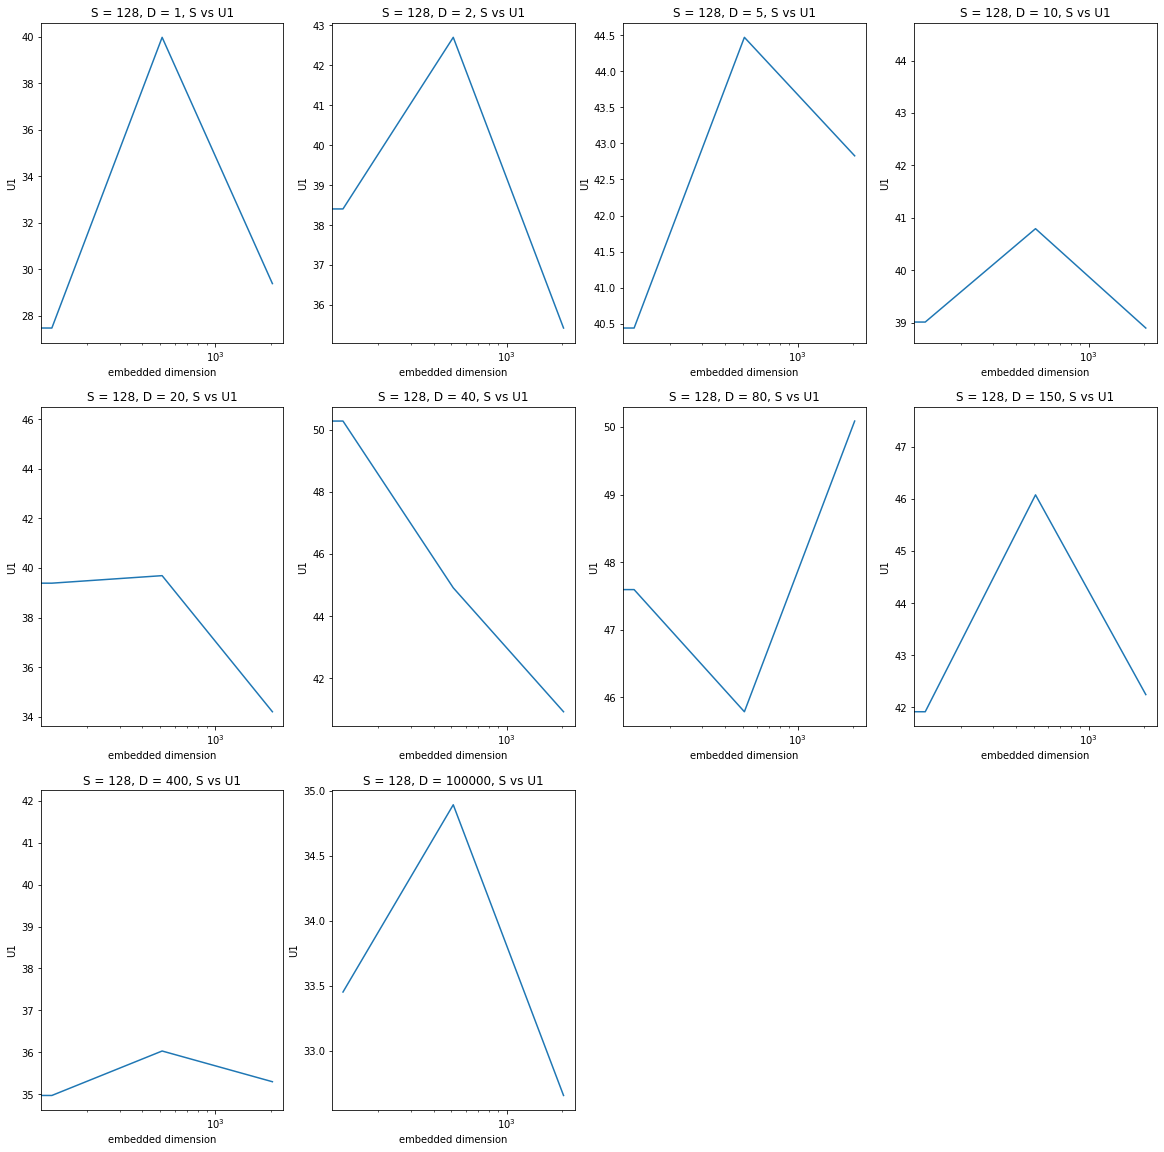

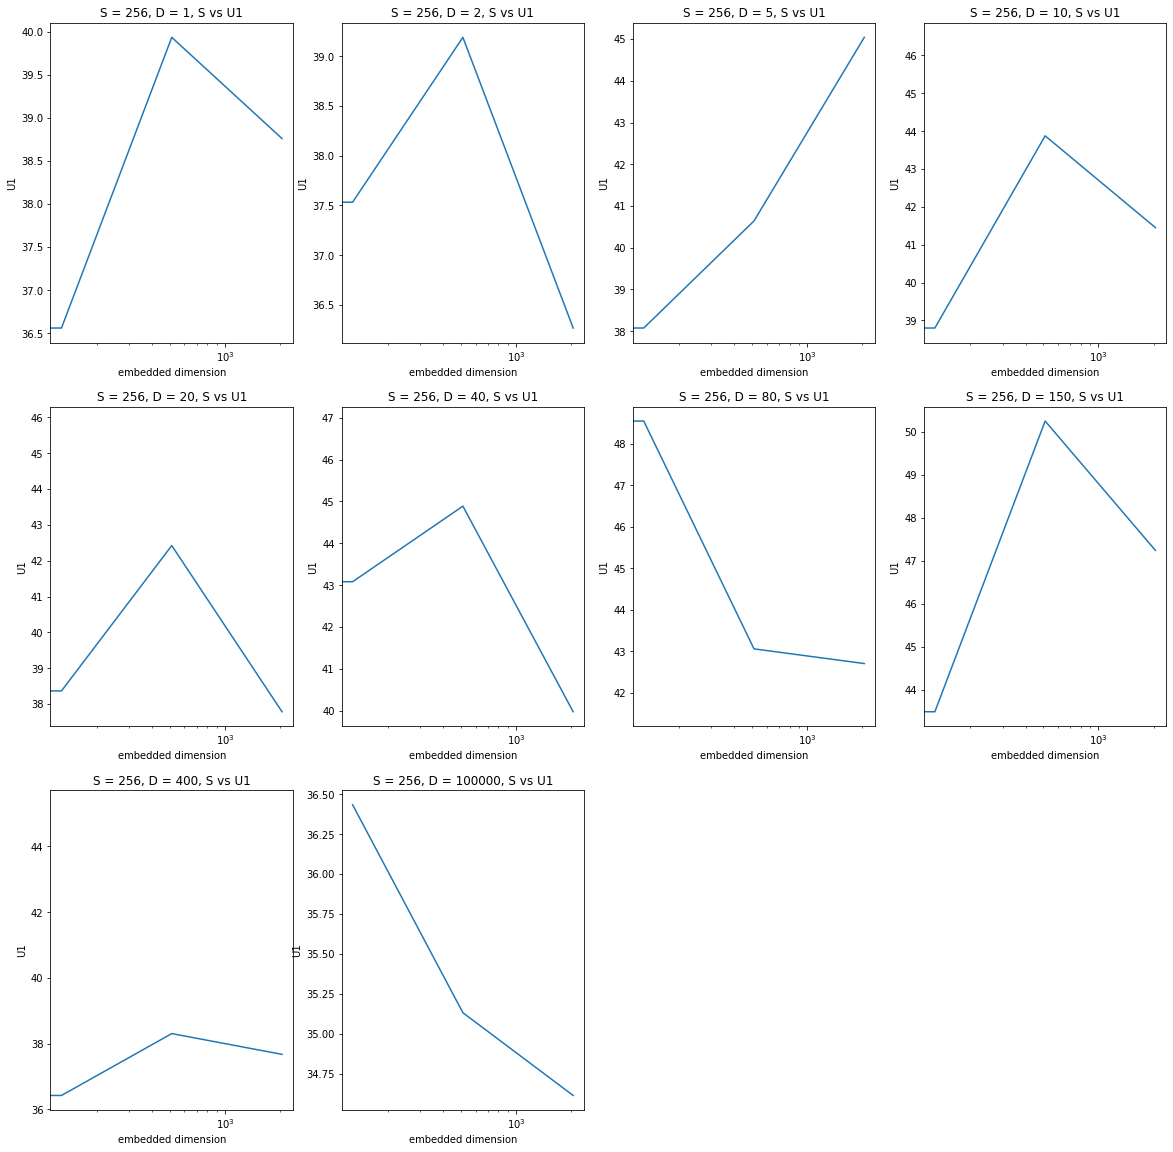

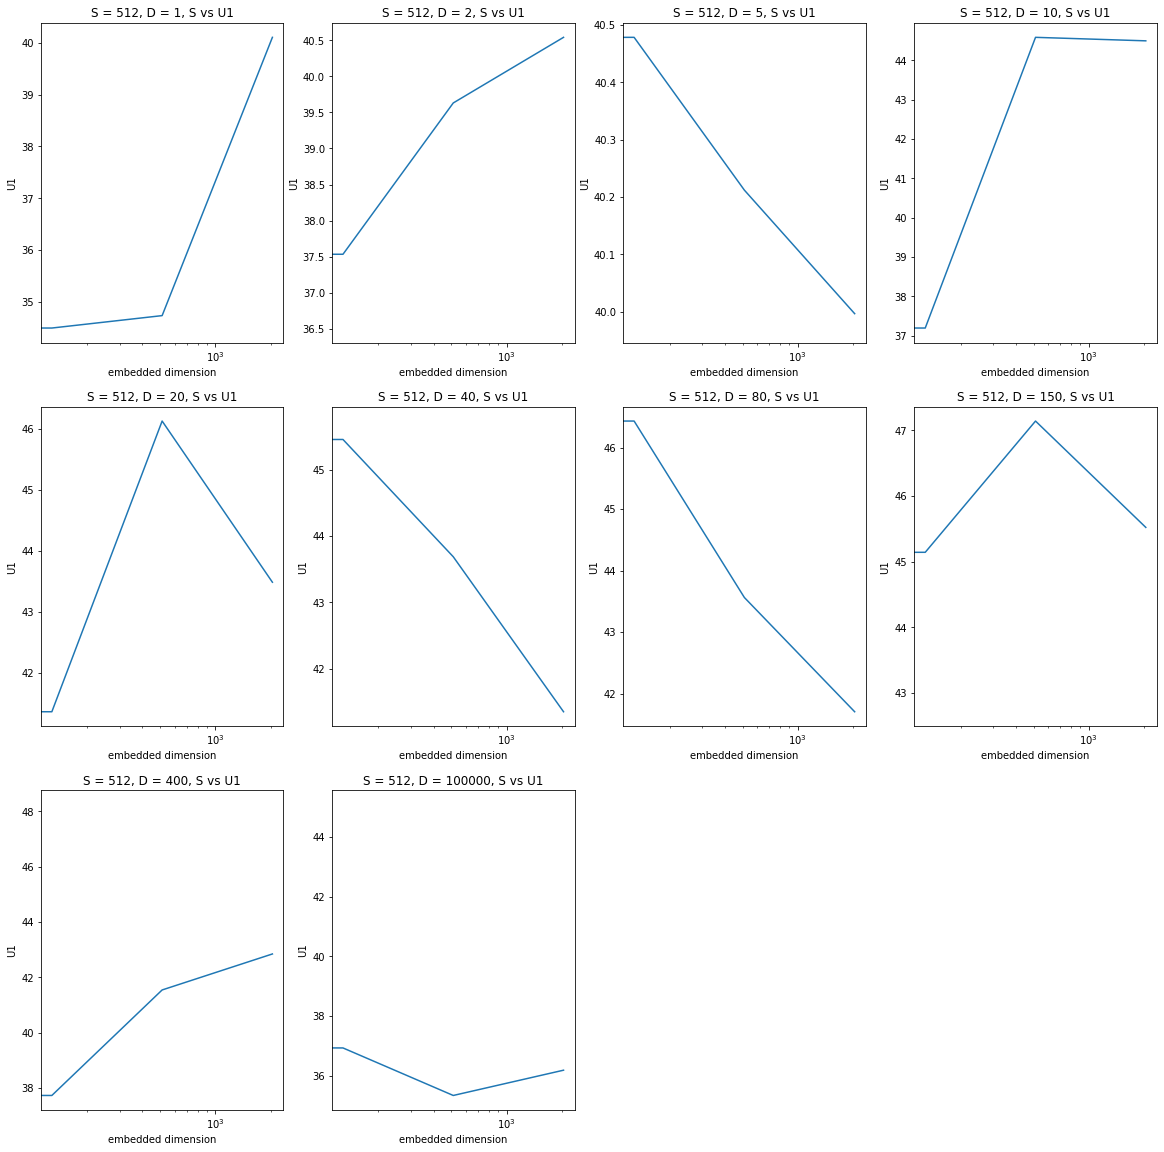

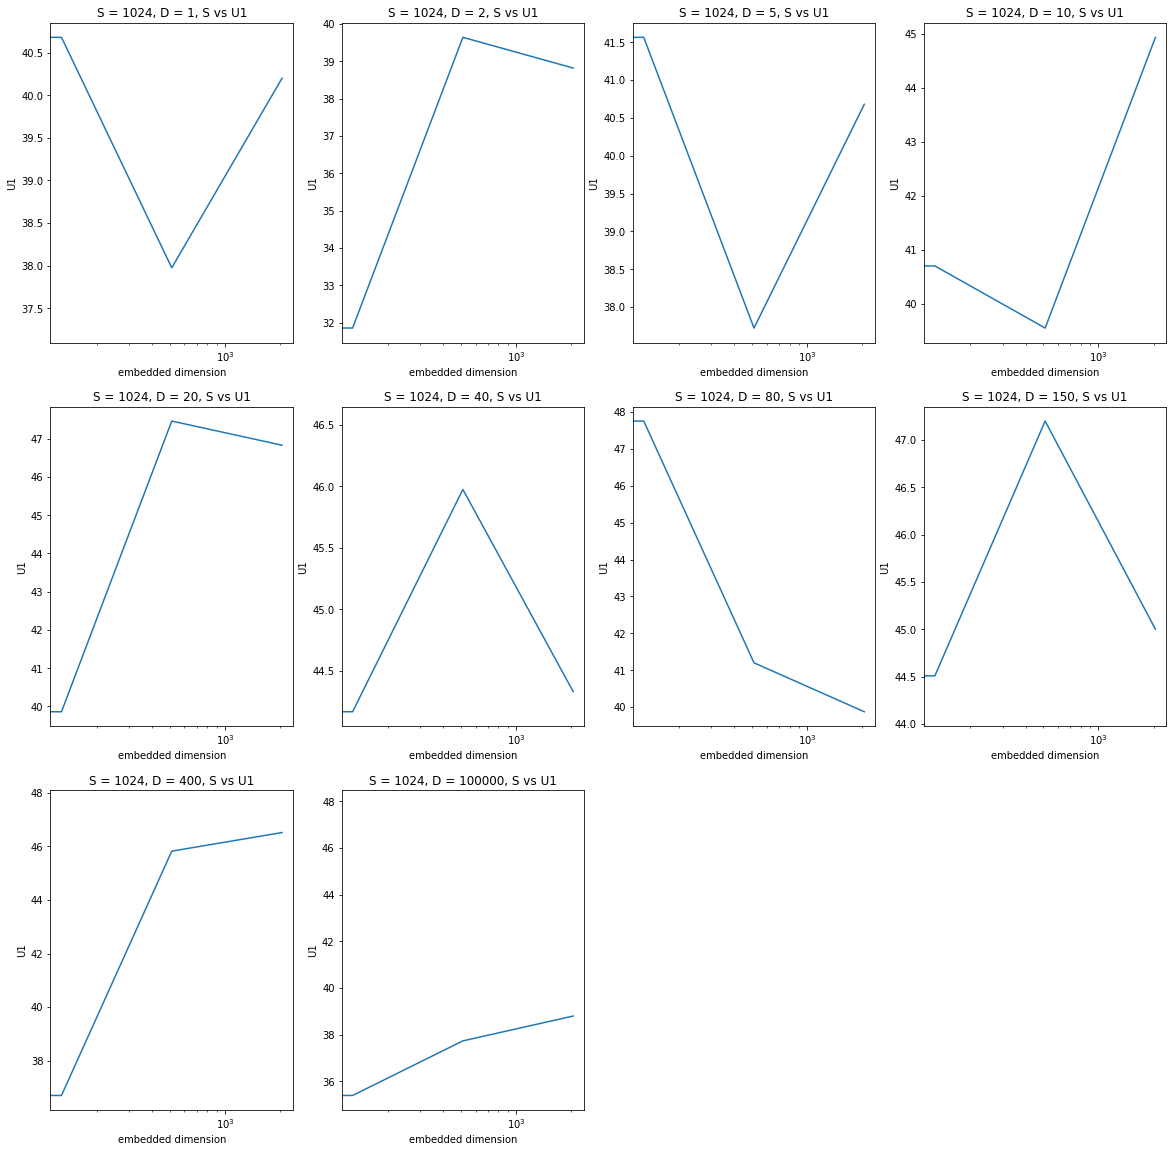

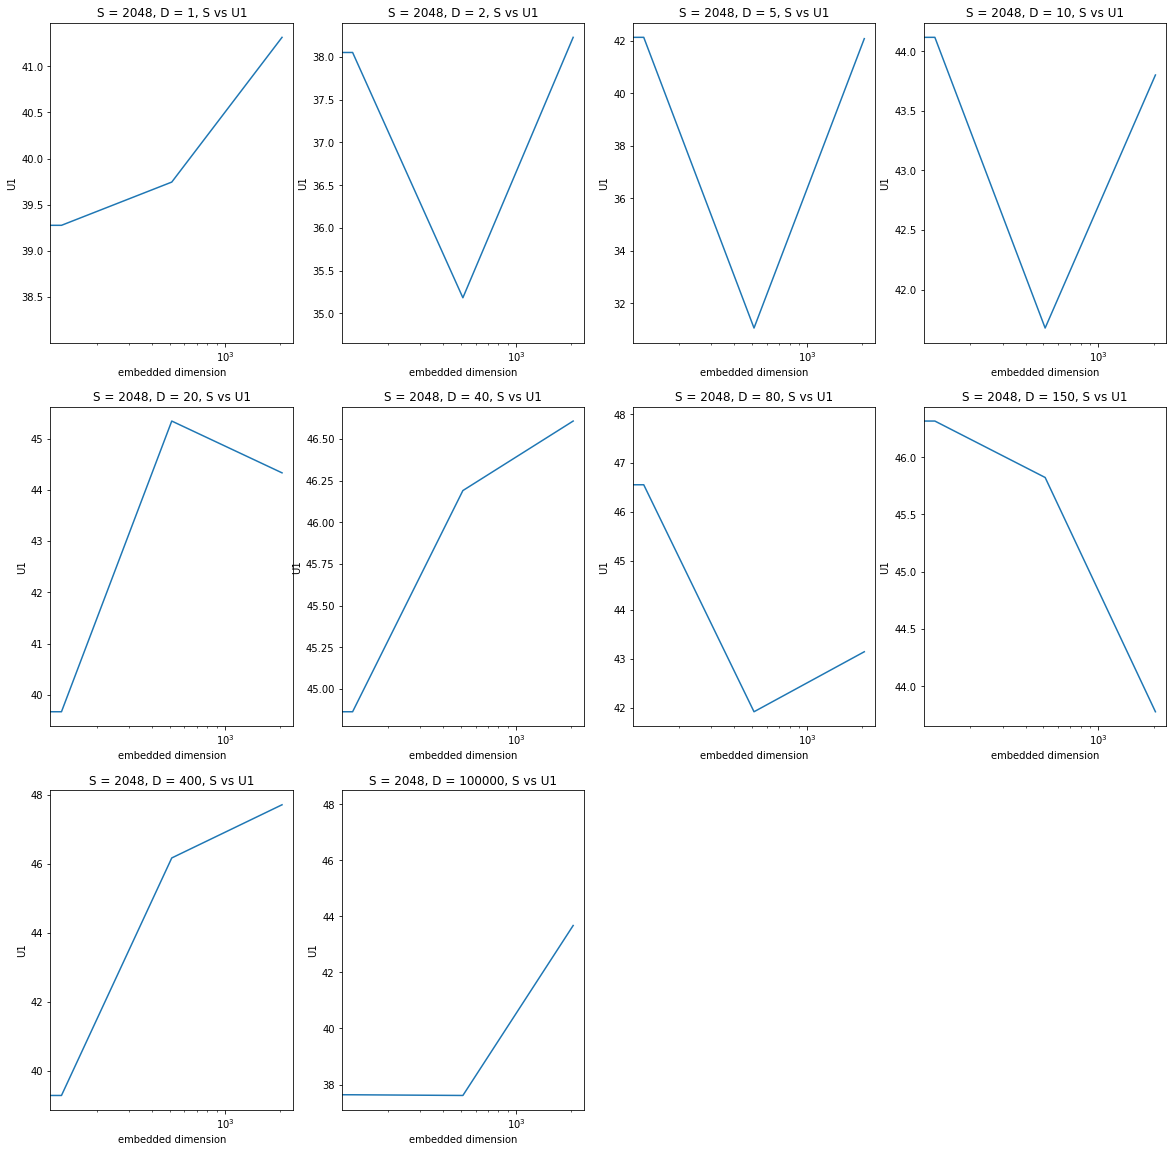

In [89]:
for s in [2,4,8,16,32,64,128,256,512,1024,2048]:
    plt.figure(figsize=(20,20))
    i = 0
    for d in [1,2,5,10,20,40,80,150,400,100000]:
        plt.subplot(3,4,i+1)
        plt.grid(False)
        plt.title("S = {}, D = {}, S vs U1".format(s,d))
        plt.xscale("log")
        plt.xlabel("embedded dimension")
        plt.ylabel("U1")
        rows = df.loc[(df["S"] == s) & (df["D"] == d)]
        plt.plot(rows['F'], rows['U1'])
        i+=1

## Hidden layer size vs Harmonic 

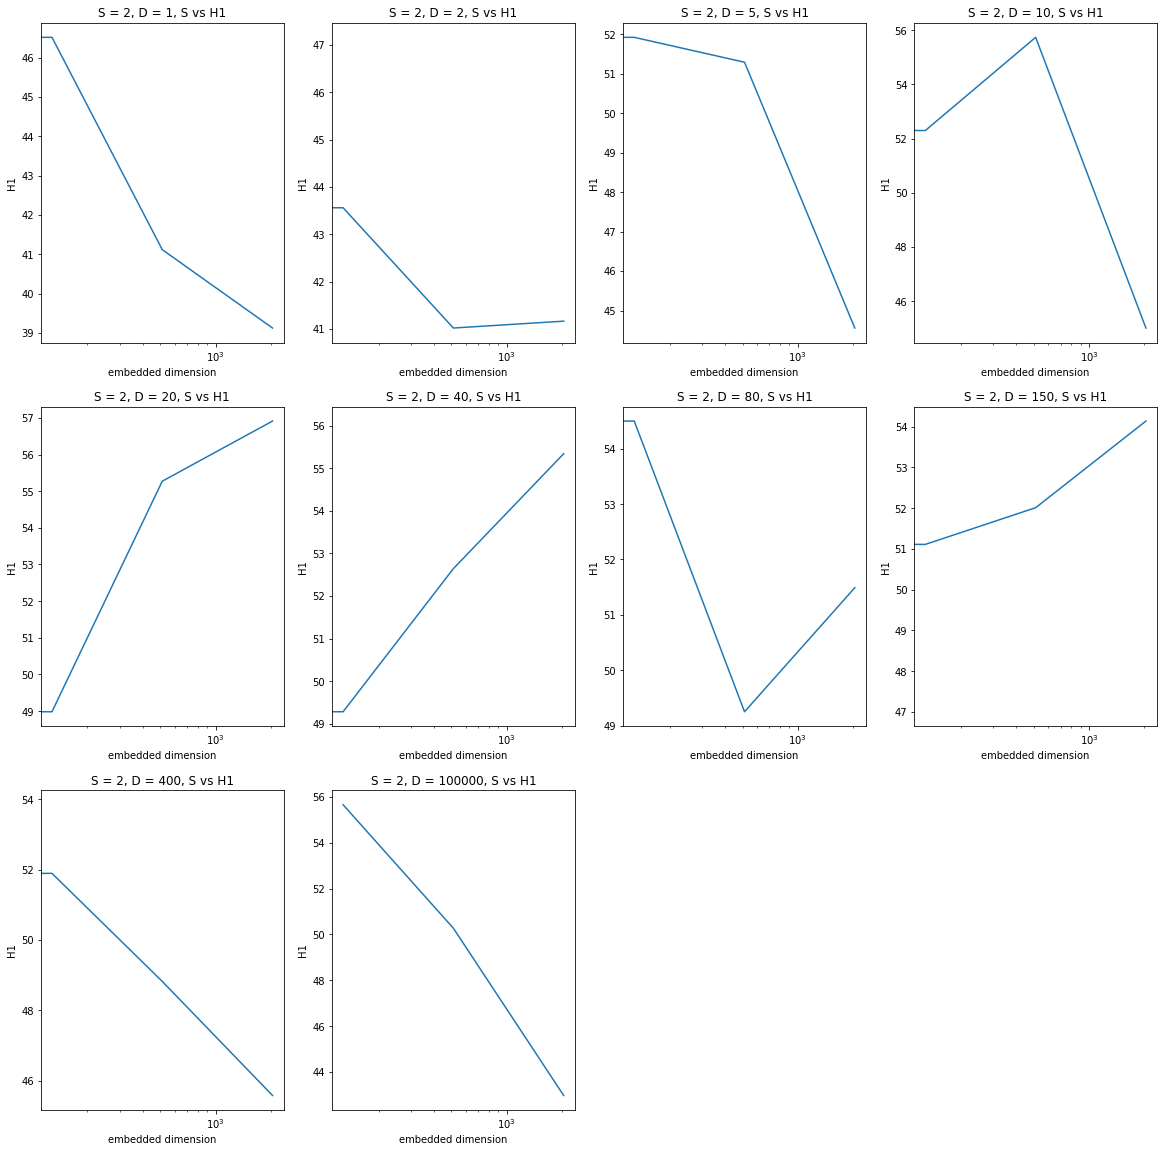

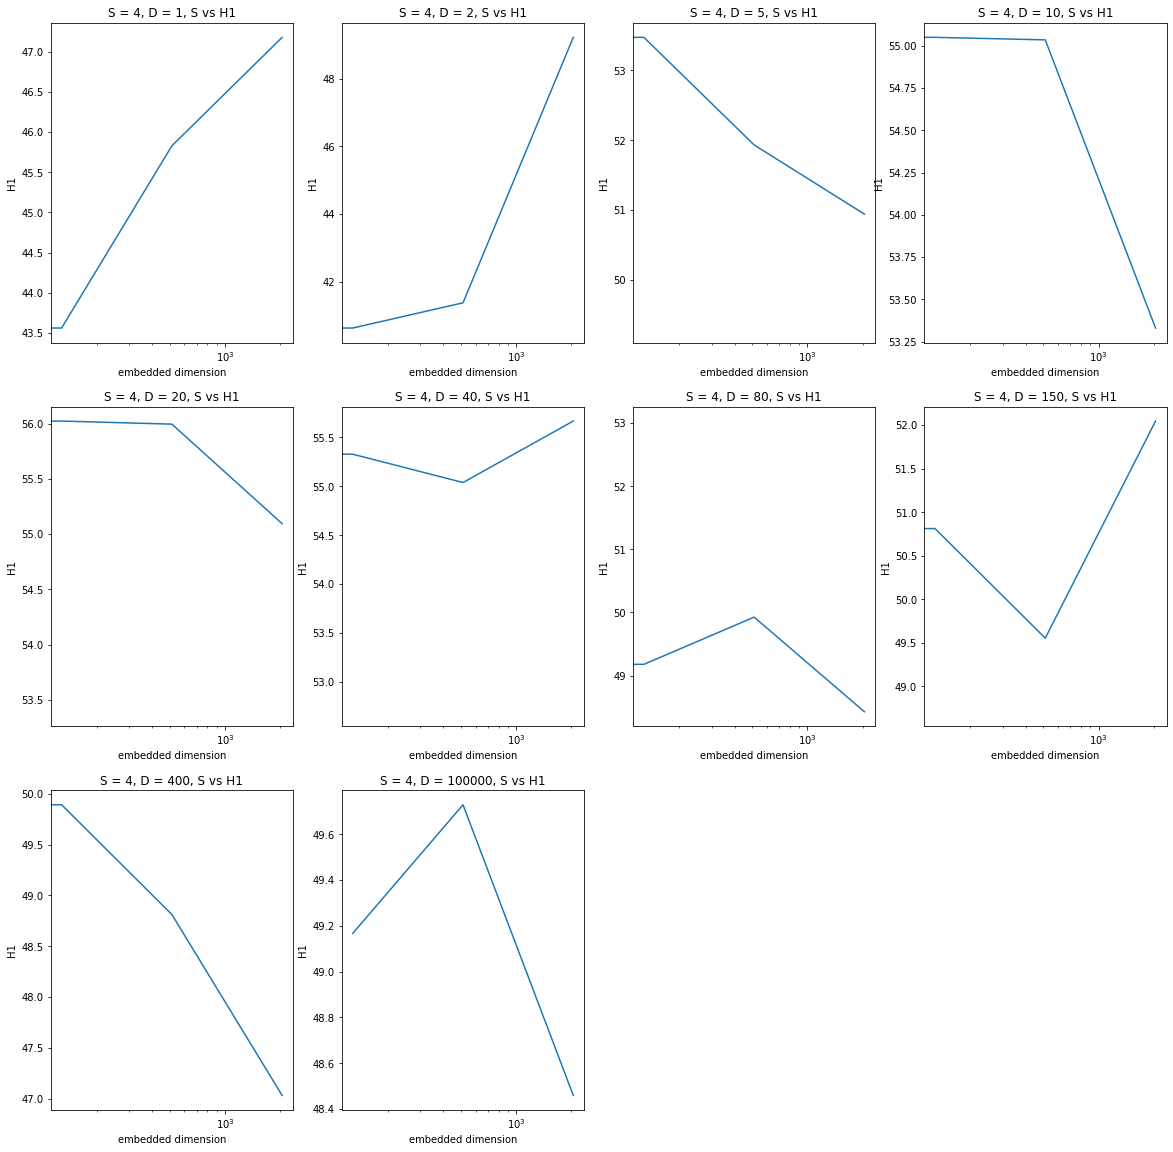

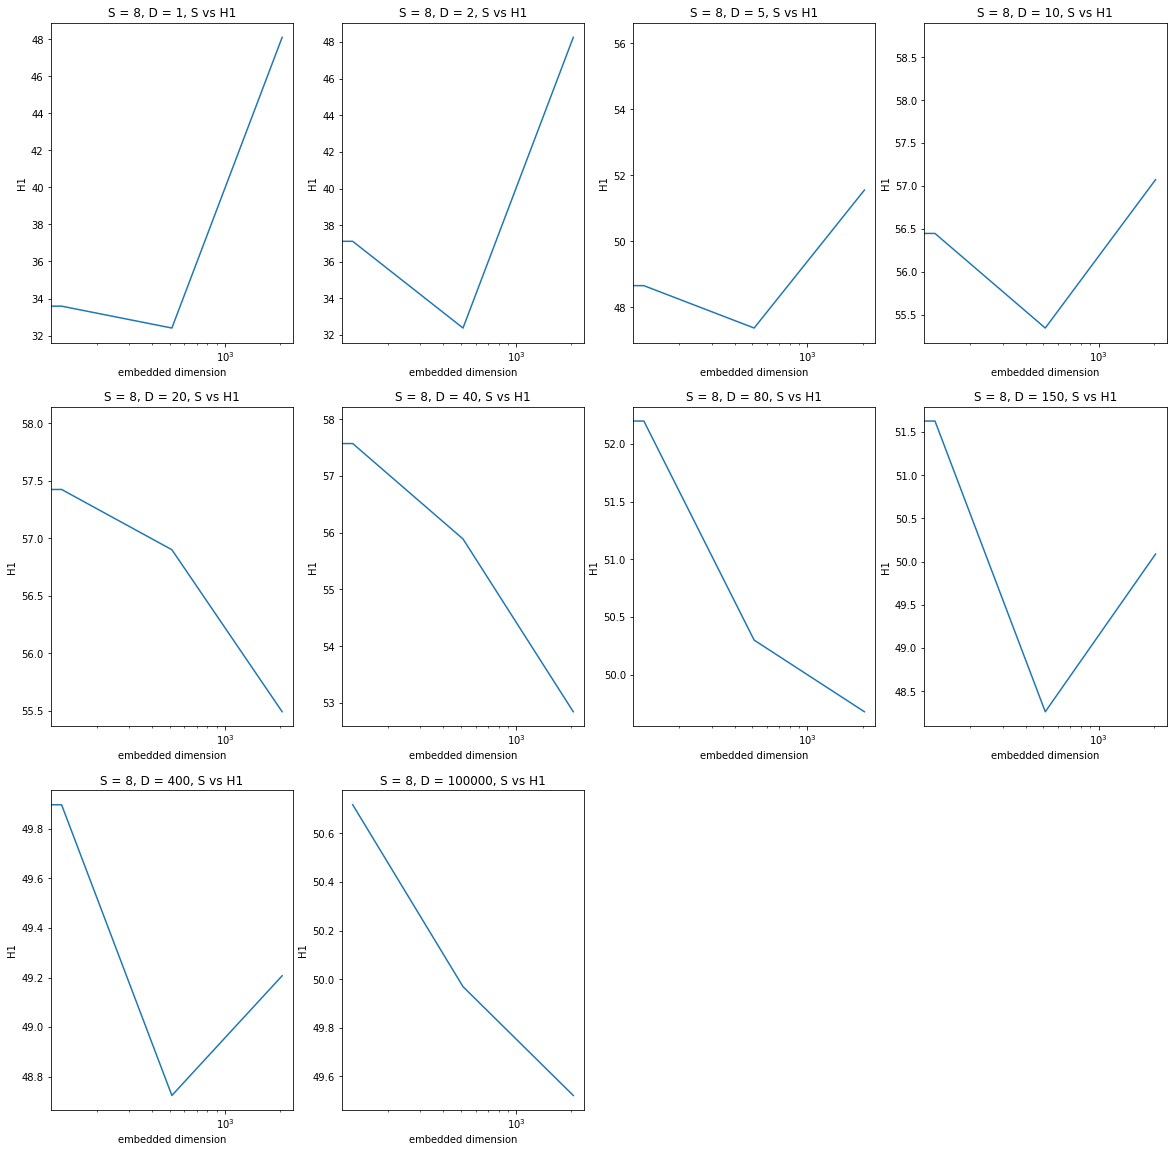

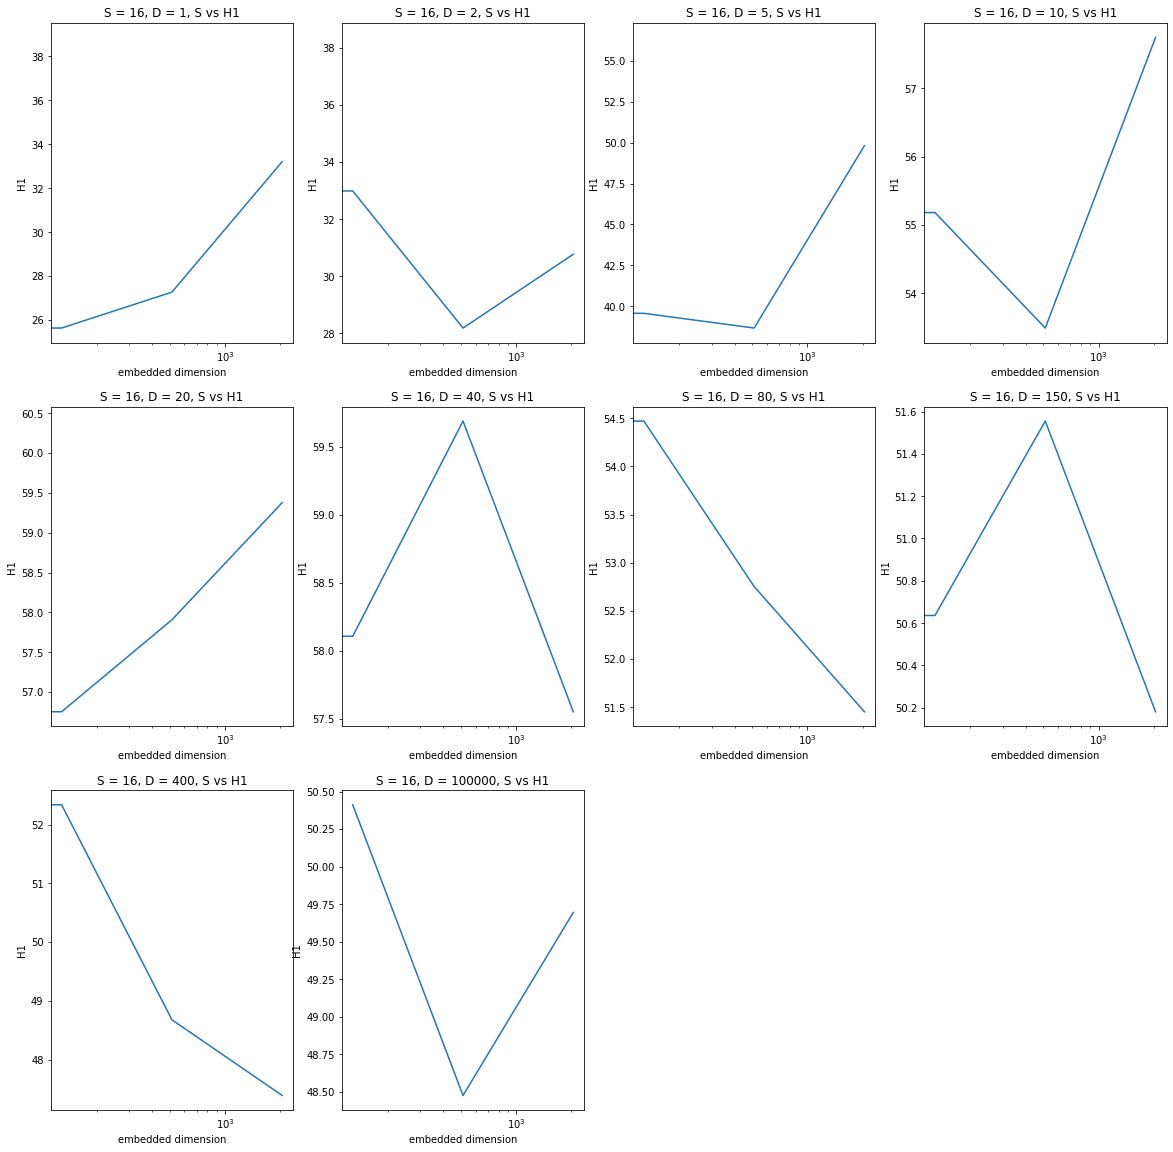

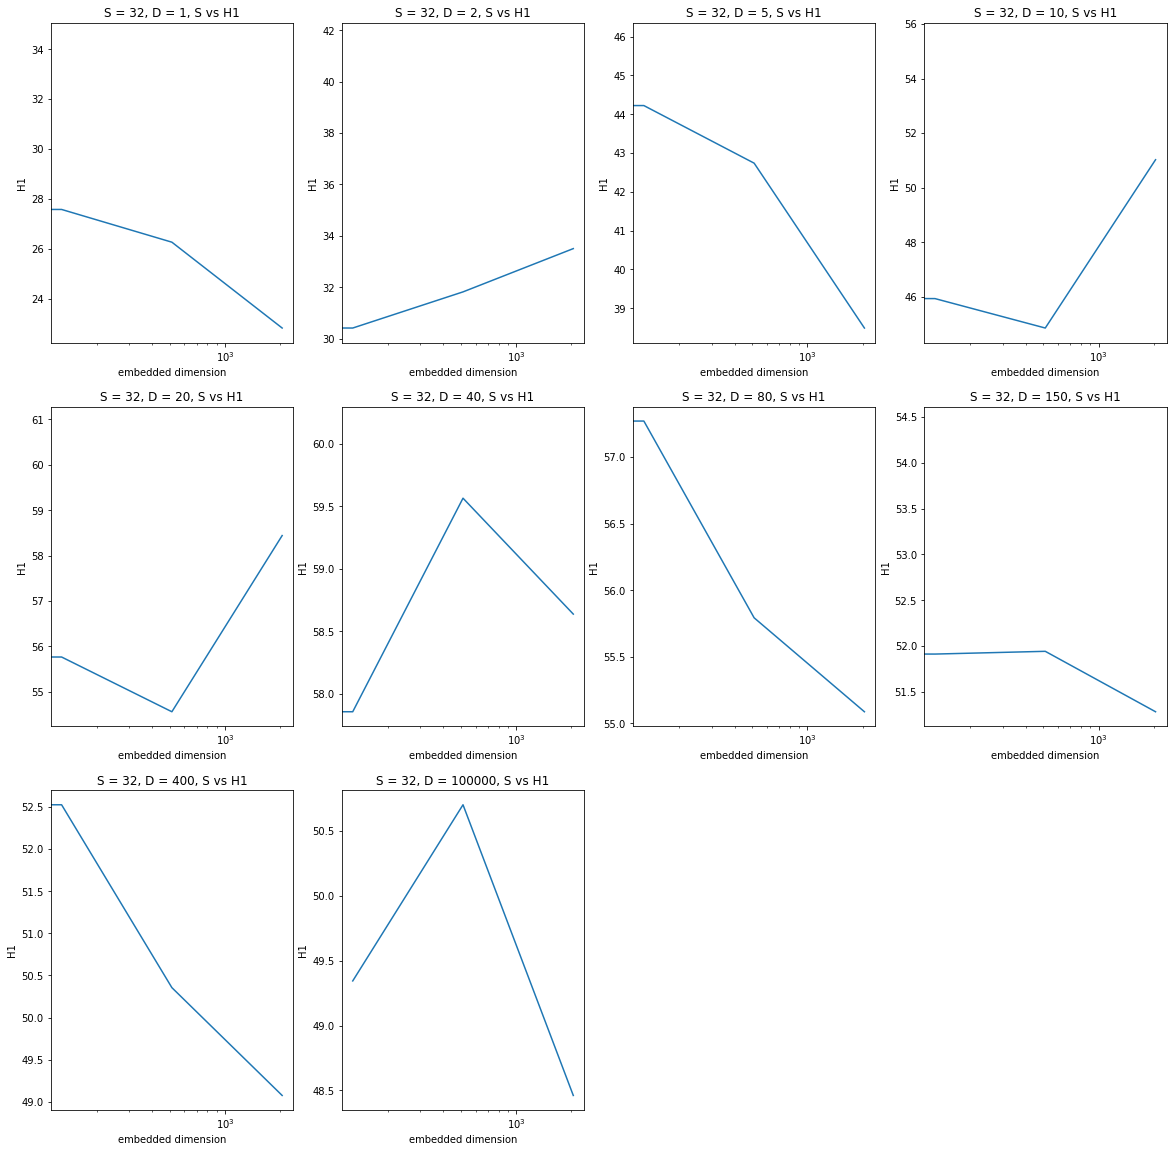

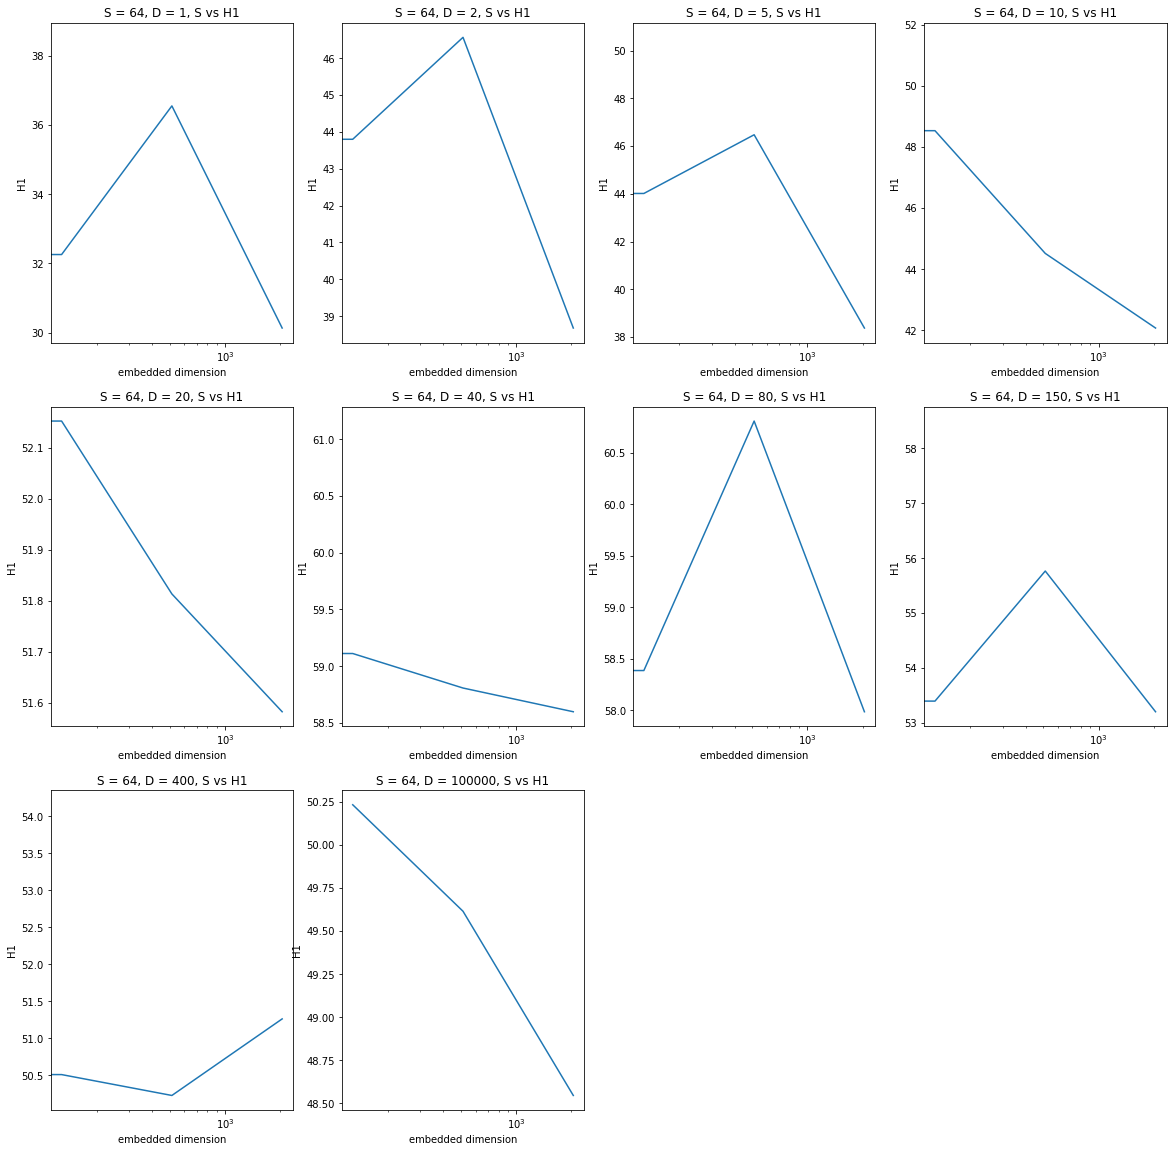

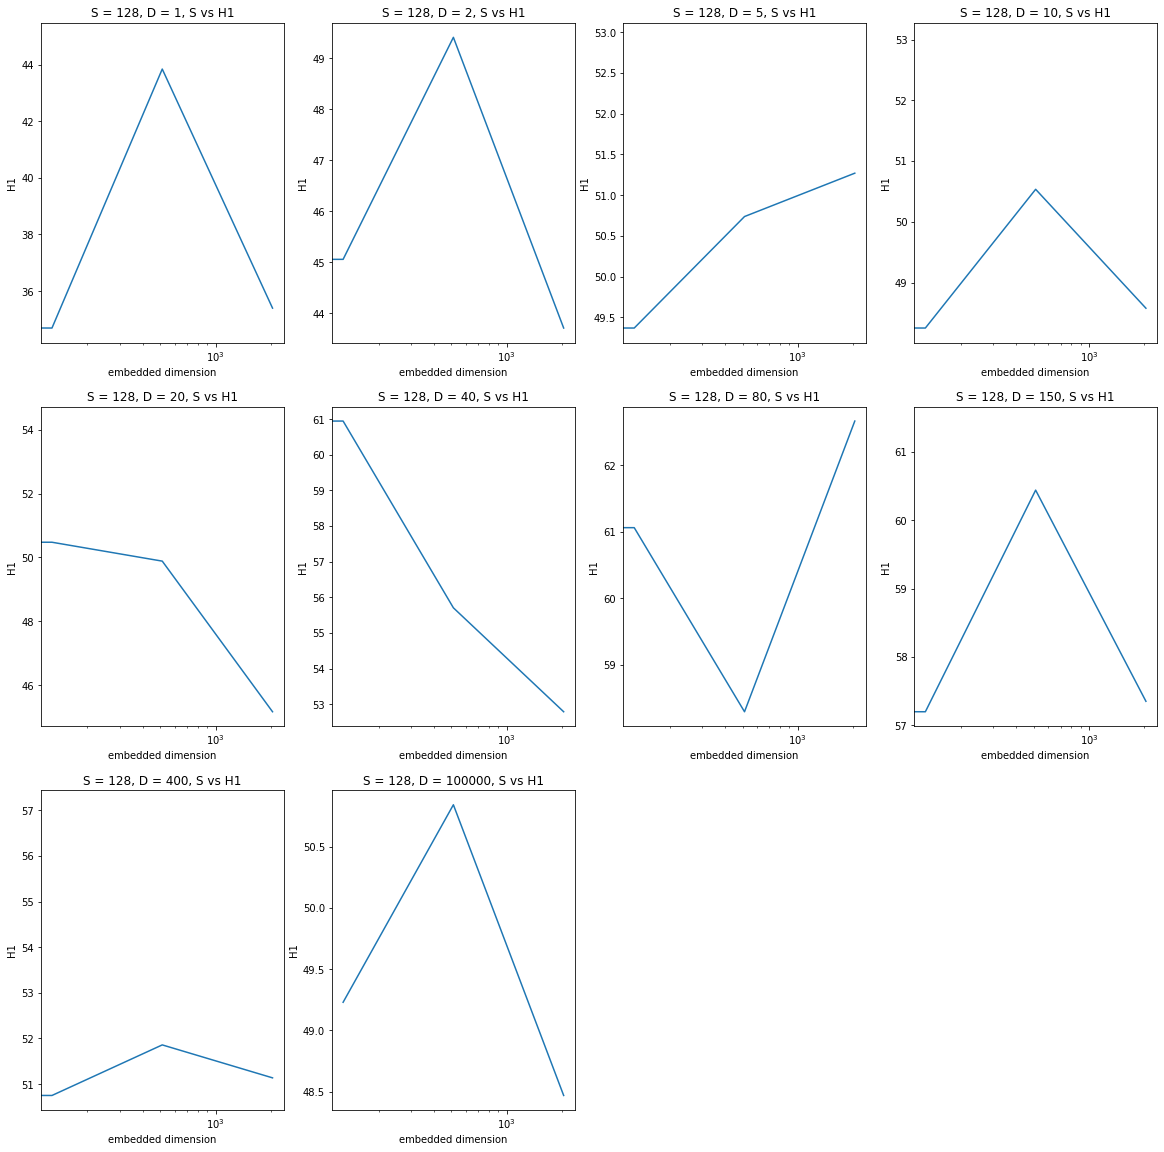

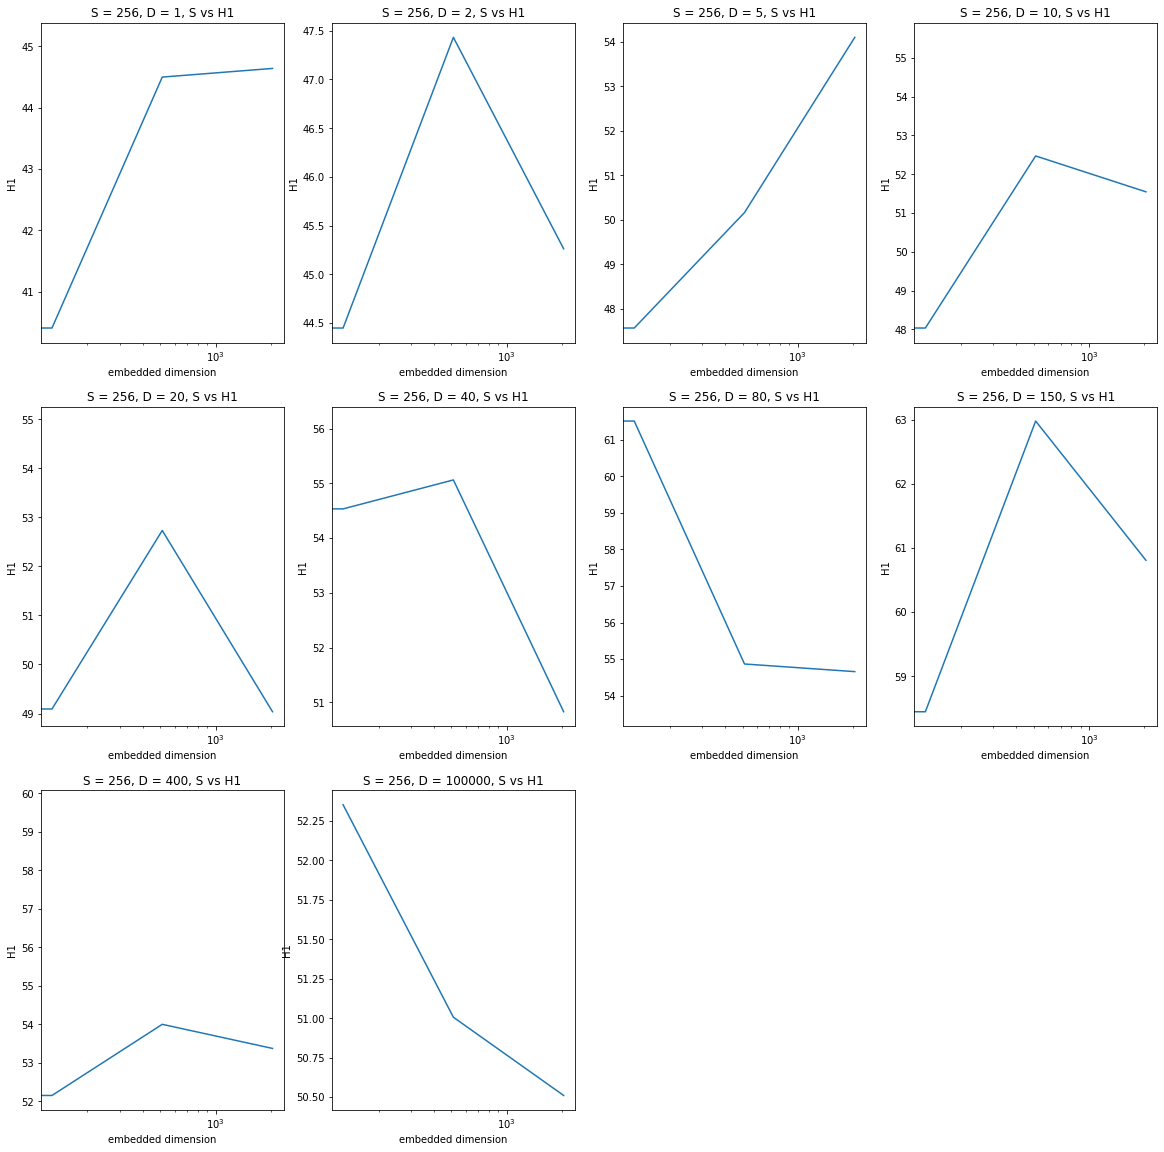

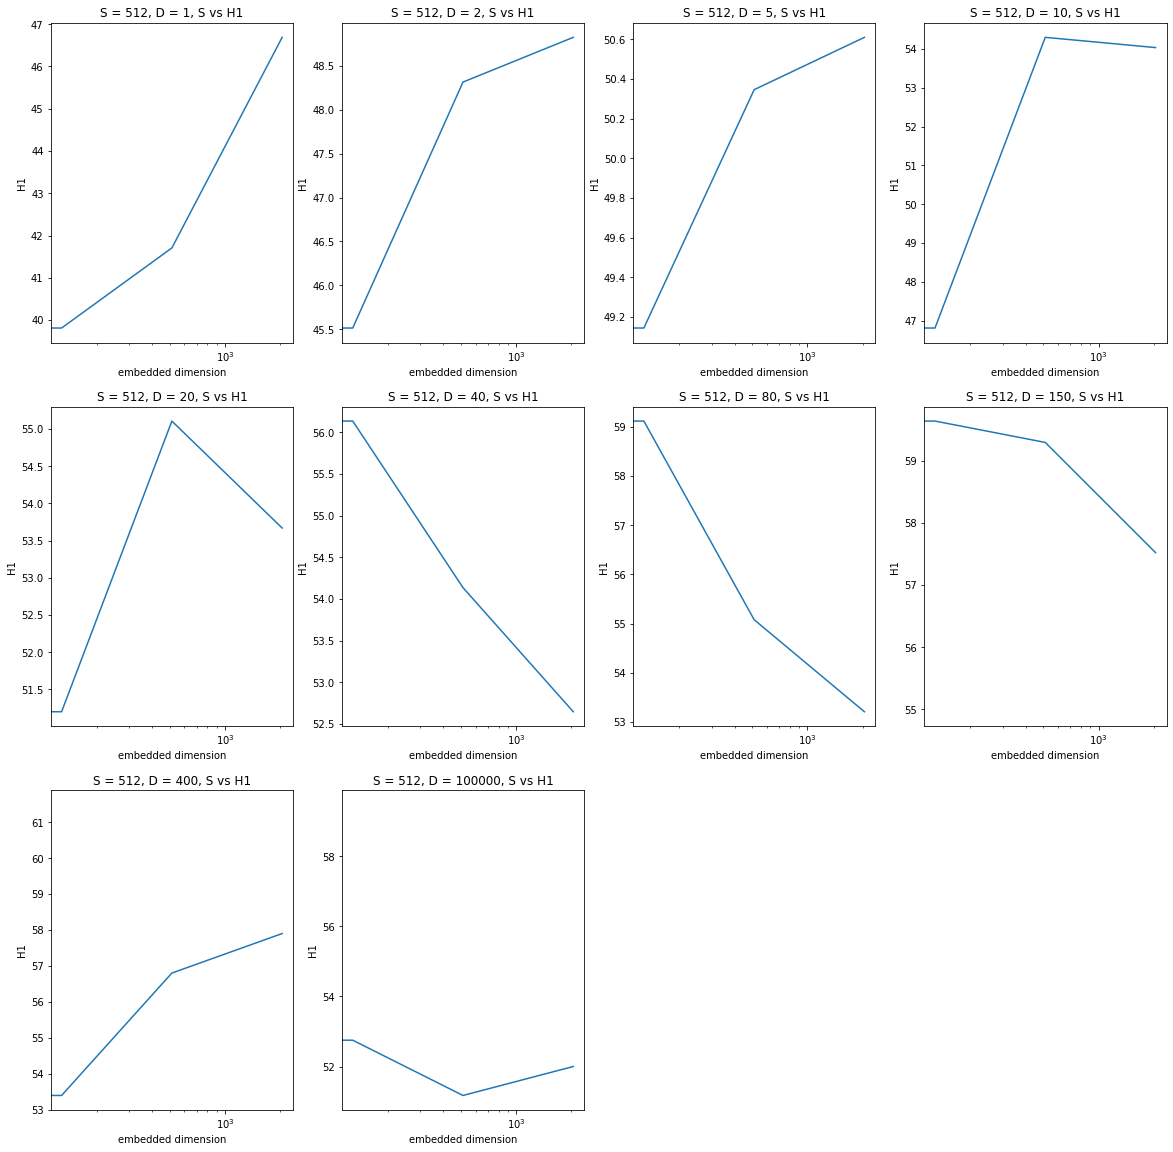

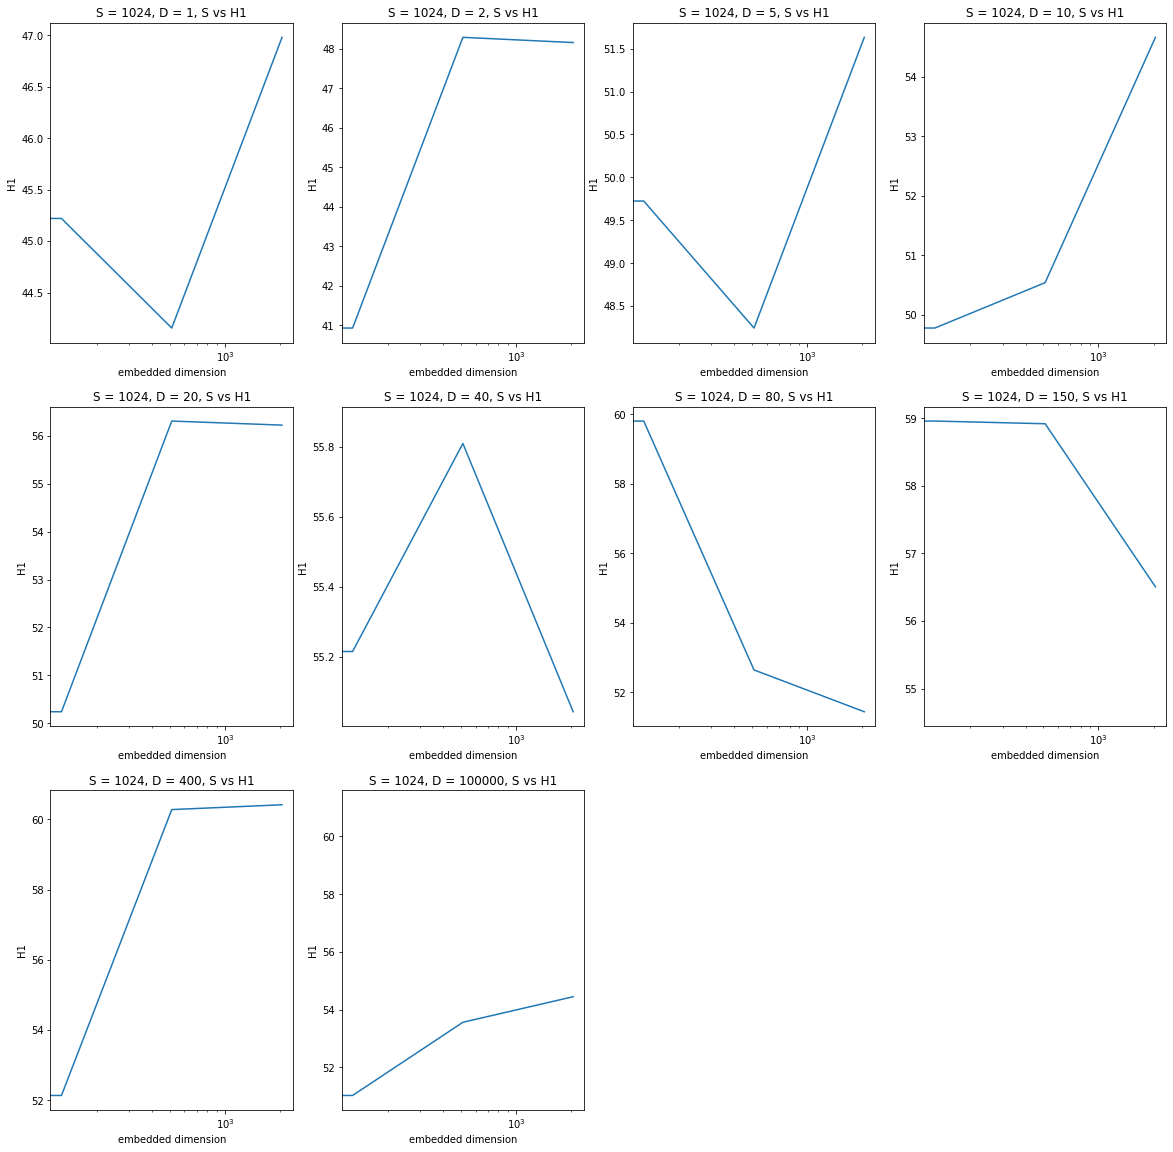

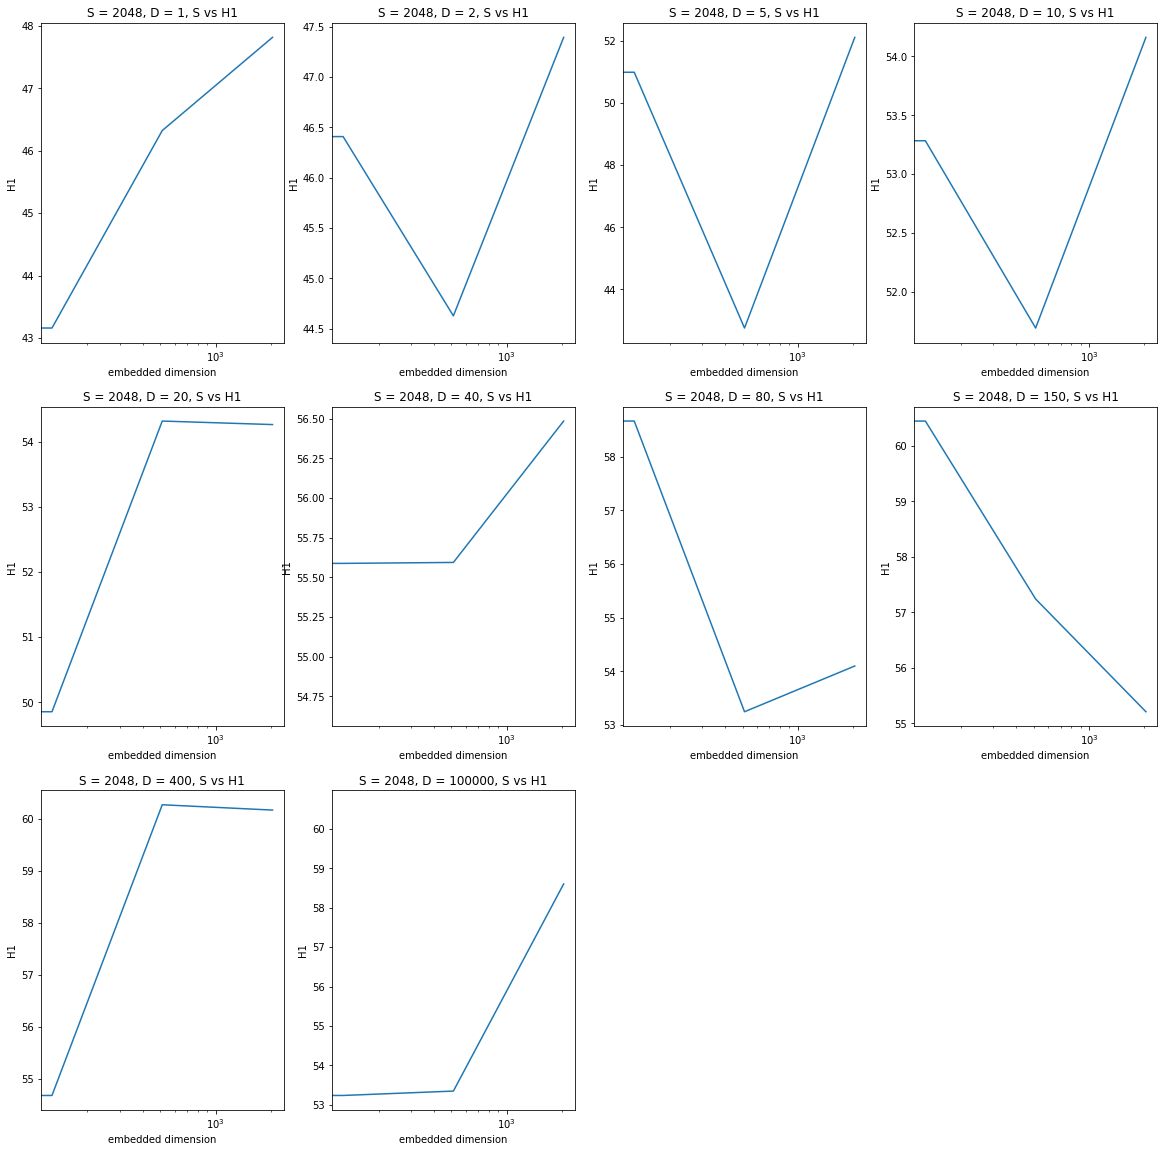

In [90]:
for s in [2,4,8,16,32,64,128,256,512,1024,2048]:
    plt.figure(figsize=(20,20))
    i = 0
    for d in [1,2,5,10,20,40,80,150,400,100000]:
        plt.subplot(3,4,i+1)
        plt.grid(False)
        plt.title("S = {}, D = {}, S vs H1".format(s,d))
        plt.xscale("log")
        plt.xlabel("embedded dimension")
        plt.ylabel("H1")
        rows = df.loc[(df["S"] == s) & (df["D"] == d)]
        plt.plot(rows['F'], rows['H1'])
        i+=1